In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter
import os
import scipy.stats as scs
import os.path
from os import path
from sklearn.linear_model import LinearRegression
import mdtraj as md
import shutil
import sys
sys.path.append('/storage1/francesco/PROJECTS/BLOCKING/WIP/')
from main import BlockAnalysis
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import string
from localcider.sequenceParameters import SequenceParameters
import multiprocessing as mp
from scipy.stats import pearsonr

In [15]:
def kde(a, w=None):
    if w is None:
        w = np.full(len(a), 1)
    min_ = np.min(a)
    max_ = np.max(a)
    x = np.linspace( min_, max_, num = 50 )
    d = scs.gaussian_kde( a, bw_method = "silverman", weights = w ).evaluate(x)
    u = 1./np.average(1./a, weights = w)
    return x,d,u

def kde_rg(a, w=None):
    if type(w) == 'NoneType':
        w = np.full(len(a), 1)
    min_ = np.min(a)
    max_ = np.max(a)
    x = np.linspace( min_, max_, num = 50 )
    d = scs.gaussian_kde( a, bw_method = "silverman", weights = w ).evaluate(x)
    u = np.average(a, weights = w)
    return x,d,u

def autocorrelation(x):
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

def autoblock(x):
    blocks = BlockAnalysis(x)
    stat = blocks.stat
    tc, err = blocks.err()
    plt.errorbar(stat[...,0]/200,stat[...,1],stat[...,2],fmt='ro',ms=2)
    plt.scatter(tc/200,err,c='k',zorder=300,s=5)
    plt.ylabel('SEM [nm]')
    plt.xlabel('Block length [ns]')
    plt.show()
    return blocks.x.mean(), err

def fix_topology(t,seq):
    cgtop = md.Topology()
    cgchain = cgtop.add_chain()
    for res in seq:
        cgres = cgtop.add_residue(res, cgchain)
        cgtop.add_atom('CA', element=md.element.carbon, residue=cgres)
    traj = md.Trajectory(t.xyz, cgtop, t.time, t.unitcell_lengths, t.unitcell_angles)
    traj = traj.superpose(traj, frame=0)
    return traj

def calcRs(traj):
    pairs = traj.top.select_pairs('all','all')
    d = md.compute_distances(traj,pairs)
    dmean = d.mean(axis=0)
    ij = np.array(range(1,traj.n_atoms))
    diff = [x[1]-x[0] for x in pairs]
    dij = np.empty(0)
    for i in ij:
        dij = np.append(dij,dmean[diff==i].mean())
    return ij, dij, d.max()

In [16]:
mpl.style.use('default')
prop_cycle = plt.rcParams['axes.prop_cycle']
c = prop_cycle.by_key()['color']

In [17]:
name = ('Hst5', 'Sic1', 'aSyn', 'Tau', 'GHR-ICD', 'NHE6cmdd', 'ANAC046', 'RS', 'DSS1', 'ProTa','A1')

In [31]:
os.getwcwd

AttributeError: module 'os' has no attribute 'getwcwd'

### Building dataset

In [18]:
# Write correct Rh and error for A1
dataset = {}
dataset['name'] = name
dataset['Rh'] = (1.275, 2.15, 2.79, 5.4, 5.08, 2.67, 3.04, 1.19, 1.70, 2.89, 2.29)
dataset['Rh_err'] = (0.024, 0.11, 0.03, 0.2, 0.02, 0.02, 0.01, 0.01, 0.06, 0.08, 0.06)
dataset['sequence'] = [open('/storage1/francesco/PROJECTS/ENSEMBLES/TSCL-M1/{:s}.fasta'.format(x,x)).readlines()[1].strip() for x in dataset['name']]
dataset['length'] = [len(x) for x in dataset['sequence']]

dataset = pd.DataFrame(dataset).sort_values('length').set_index('name')
dataset.to_csv('/storage1/francesco/PROJECTS/EXP_DATA/Rh.csv')

In [19]:
dataset

Rh  Rh_err                                           sequence  \
name                                                                         
Hst5      1.275   0.024                           DSHAKRHHGYKRKFHEKHHSHRGY   
RS        1.190   0.010                           GAMGPSYGRSRSRSRSRSRSRSRS   
DSS1      1.700   0.060  MSRAALPSLENLEDDDEFEDFATENWPMKDTELDTGDDTLWENNWD...   
Sic1      2.150   0.110  MTPSTPPRSRGTRYLAQPSGNTSSSALMQGQKTPQKPSQNLVPVTP...   
ProTa     2.890   0.080  GPSDAAVDTSSEITTKDLKEKKEVVEEAENGRDAPANGNANEENGE...   
NHE6cmdd  2.670   0.020  GPPLTTTLPACCGPIARCLTSPQAYENQEQLKDDDSDLILNDGDIS...   
A1        2.290   0.060  GSMASASSSQRGRSGSGNFGGGRGGGFGGNDNFGRGGNFSGRGGFG...   
aSyn      2.790   0.030  MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...   
ANAC046   3.040   0.010  NAPSTTITTTKQLSRIDSLDNIDHLLDFSSLPPLIDPGFLGQPGPS...   
GHR-ICD   5.080   0.020  SKQQRIKMLILPPVPVPKIKGIDPDLLKEGKLEEVNTILAIHDSYK...   
Tau       5.400   0.200  MAEPRQEFEVMEDHAGTYGLGDRKDQGGYTMHQDQEGDTDAGLKES...   

          length  
name              
Hst5          24  
RS            24  
DSS1          71  
Sic1          90  
ProTa        111  
NHE6cmdd     116  
A1           137  
aSyn         140  
ANAC046      167  
GHR-ICD      351  
Tau          441

In [20]:
avg_rel_err = np.average([dataset.Rh_err[p] / dataset.Rh[p] for p in dataset.index])

In [21]:
avg_rel_err

0.020915743348596486

In [22]:
dataset['Rh_rel_err'] = [e*avg_rel_err for e in dataset.Rh]

In [23]:
names_form = ['Hst5', 'RS', 'Dss1', 'Sic1', r'ProT$\alpha$', 'NHE6cmdd', 'A1', r'$\alpha$Syn', 'ANAC046', 'GHR-ICD', 'Tau']

### Sequence features

In [12]:
scd = []
ncpr = []
frac_pro = []
frac_plus = []
frac_minus = []
for s in dataset.sequence:
    SeqObj = SequenceParameters(s)
    scd.append( SeqObj.get_SCD() )
    ncpr.append( SeqObj.get_NCPR() )
    frac_pro.append( s.count('P')/len(s)*100 )
    frac_plus.append( SeqObj.get_fraction_positive()*100 )
    frac_minus.append( SeqObj.get_fraction_negative()*100 )

In [14]:
d = {'Length': dataset.length.values, 'SCD': np.around(np.array(scd),1), 'NCPR': np.around(np.array(ncpr),1), 'Fraction positive': np.around(np.array(frac_plus),1), 'Fraction negative': np.around(np.array(frac_minus),1), 'Fraction proline': np.around(np.array(frac_pro),1)}
d = pd.DataFrame(data=d, index=dataset.index)
d.to_latex('seq_feat.tex')

In [15]:
d

Length   SCD  NCPR  Fraction positive  Fraction negative  \
name                                                                 
Hst5          24   0.8   0.2               29.2                8.3   
RS            24   2.7   0.3               33.3                0.0   
DSS1          71   6.9  -0.3                7.0               32.4   
Sic1          90   3.5   0.1               12.2                0.0   
ProTa        111  39.5  -0.4                9.0               47.7   
NHE6cmdd     116   2.6  -0.1                6.9               17.2   
A1           137   1.3   0.1                8.8                2.9   
aSyn         140  -1.2  -0.1               10.7               17.1   
ANAC046      167   2.2  -0.1                4.2               10.8   
GHR-ICD      351  10.5  -0.1                7.4               16.0   
Tau          441  -8.1   0.0               13.2               12.7   

          Fraction proline  
name                        
Hst5                   0.0  
RS                     4.2  
DSS1                   2.8  
Sic1                  16.7  
ProTa                  1.8  
NHE6cmdd               9.5  
A1                     1.5  
aSyn                   3.6  
ANAC046                8.4  
GHR-ICD                8.5  
Tau                    9.8

### Simulation analyses
#### FF: TSCL-M1; 1 us

In [11]:
residues = pd.read_csv('/storage1/francesco/PROJECTS/IDP_EVO/MAIN/residues.csv').set_index('one', drop=False)

In [12]:
# Load trajectories
traj = {}
folder = '/storage1/francesco/PROJECTS/ENSEMBLES/TSCL-M1/'
for p in dataset.index:
    traj[p] = md.load(folder+p+'/traj.dcd', top=folder+p+'/top.pdb')

In [13]:
# Compute Rg
rg_ca = {}
for p in dataset.index:
    rg_ca[p] = md.compute_rg(traj[p])

In [568]:
acf = {}
for p in dataset.index:
    acf[p] = autocorrelation(rg_ca[p])

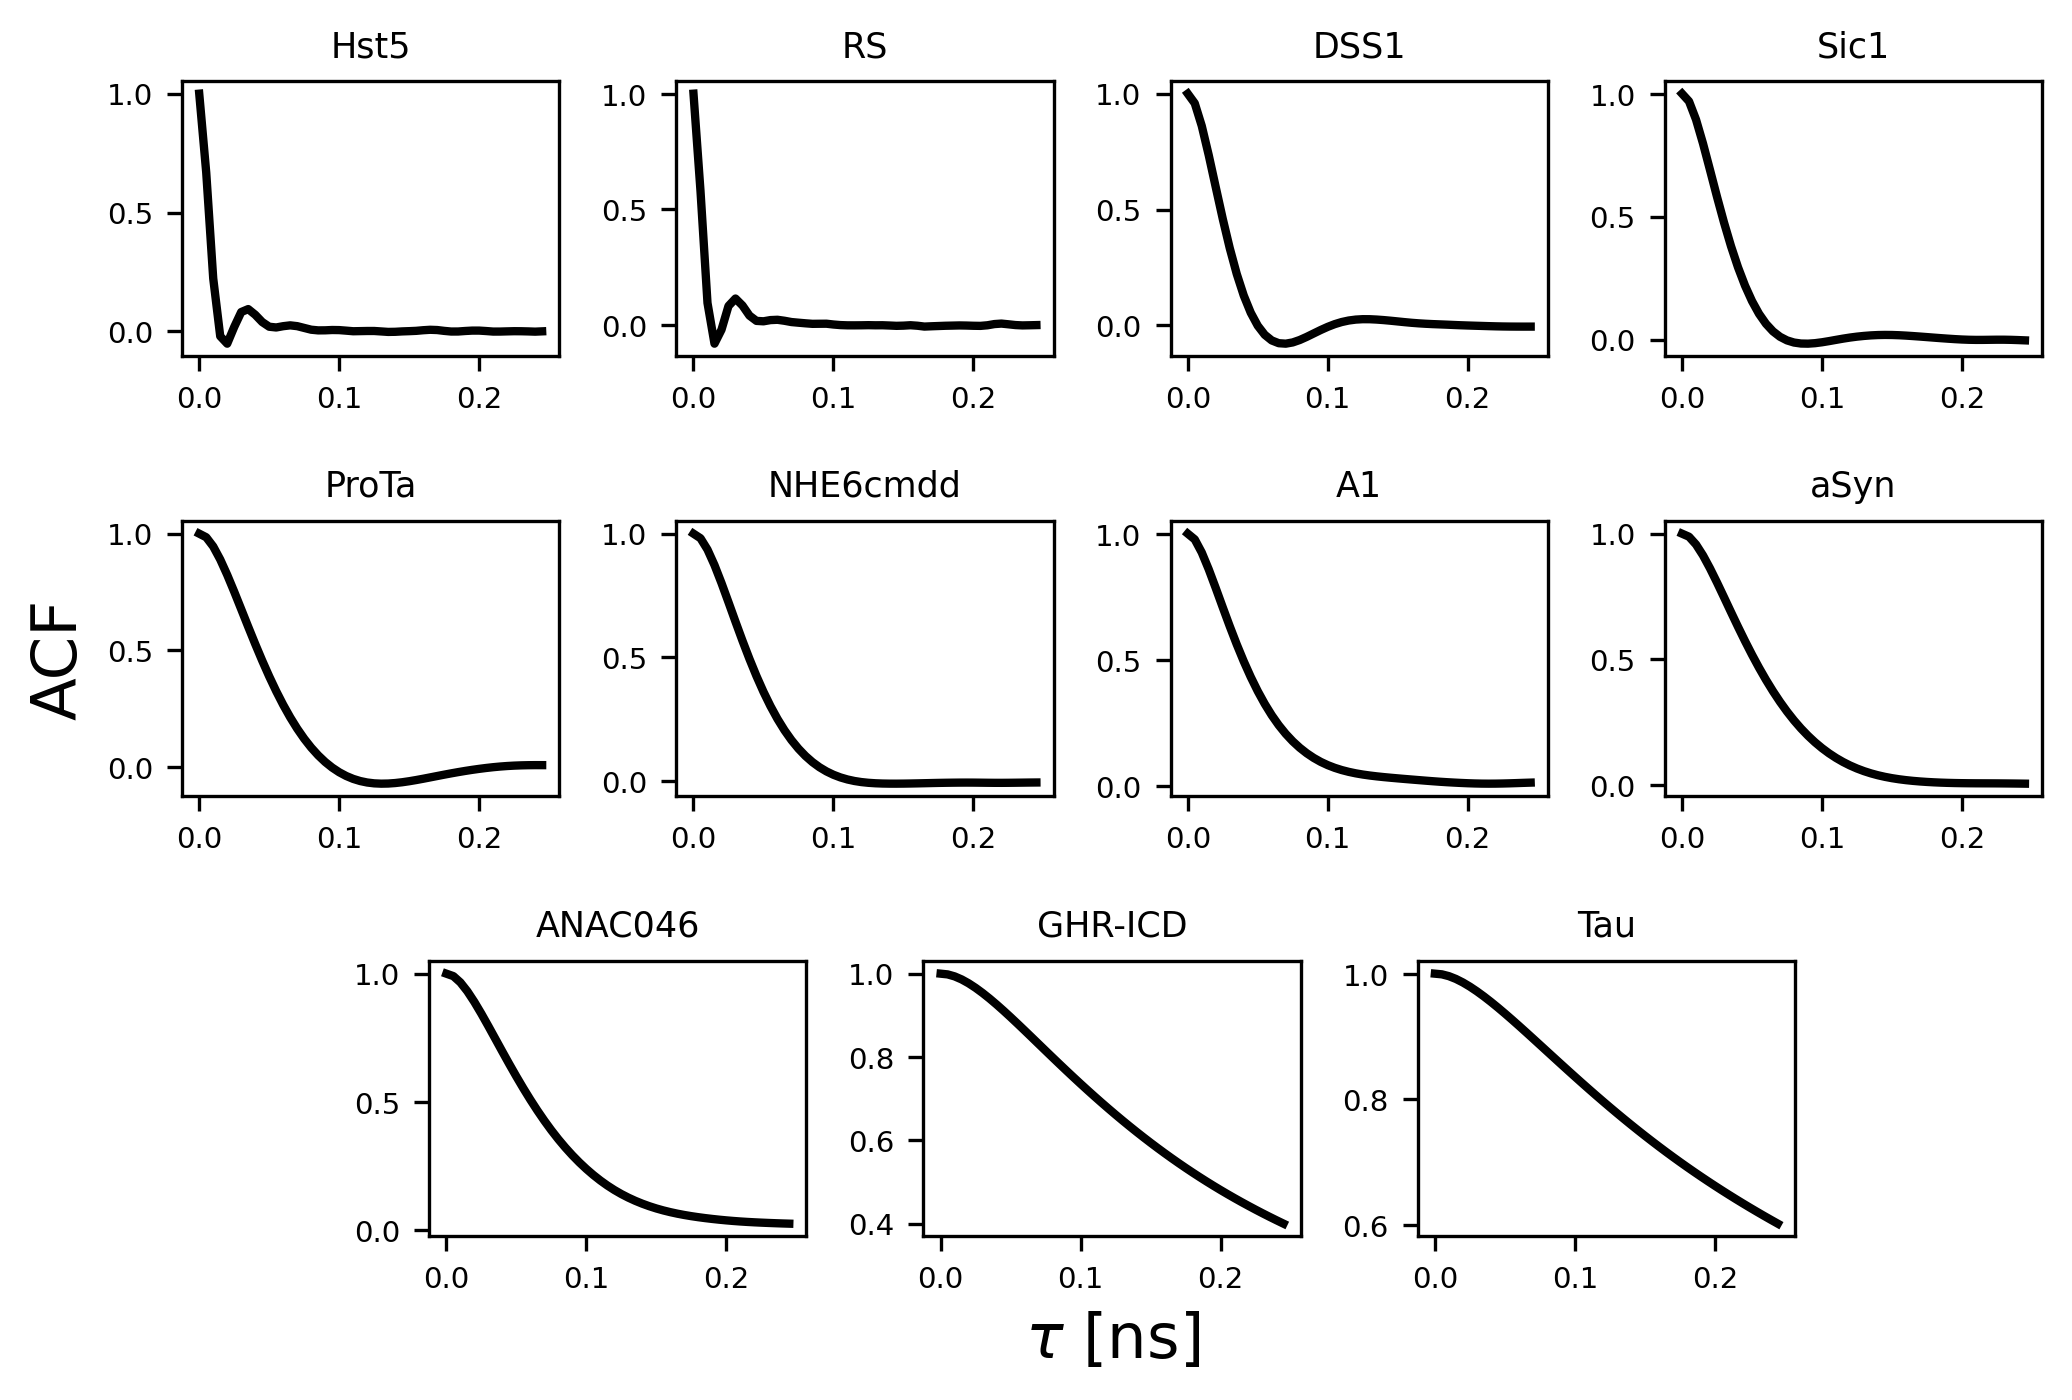

In [582]:
fig = plt.subplots(figsize=(8,5), facecolor='w', dpi=300,sharex=True)

ax1 = plt.subplot2grid(shape=(3,8), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((3,8), (0,2), colspan=2)
ax3 = plt.subplot2grid((3,8), (0,4), colspan=2)
ax4 = plt.subplot2grid((3,8), (0,6), colspan=2)
ax5 = plt.subplot2grid((3,8), (1,0), colspan=2)
ax6 = plt.subplot2grid((3,8), (1,2), colspan=2)
ax7 = plt.subplot2grid((3,8), (1,4), colspan=2)
ax8 = plt.subplot2grid((3,8), (1,6), colspan=2)
ax9 = plt.subplot2grid((3,8), (2,1), colspan=2)
ax10 = plt.subplot2grid((3,8), (2,3), colspan=2)
ax11 = plt.subplot2grid((3,8), (2,5), colspan=2)

axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11]

plt.subplots_adjust(
                    wspace=0.9, 
                    hspace=0.6)

for p, ax in zip(dataset.index, axs):
    ax.plot((np.arange(len(acf[p]))/200)[:50], acf[p][:50],c='k',linewidth=2)
    ax.set_title(p)

ax10.set_xlabel(r'$\tau$ [ns]',fontsize=15)
ax5.set_ylabel('ACF',fontsize=15)

plt.savefig('acf.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

Hst5


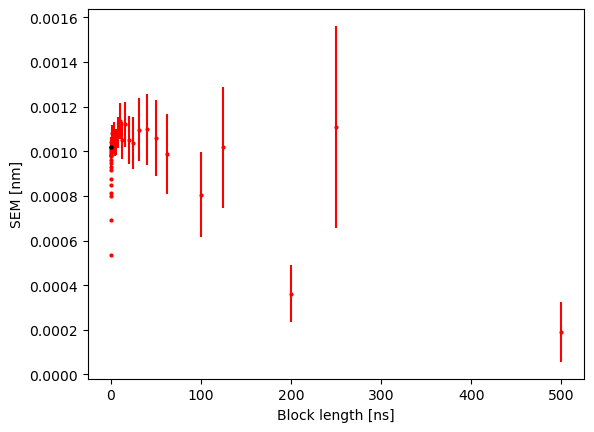

RS


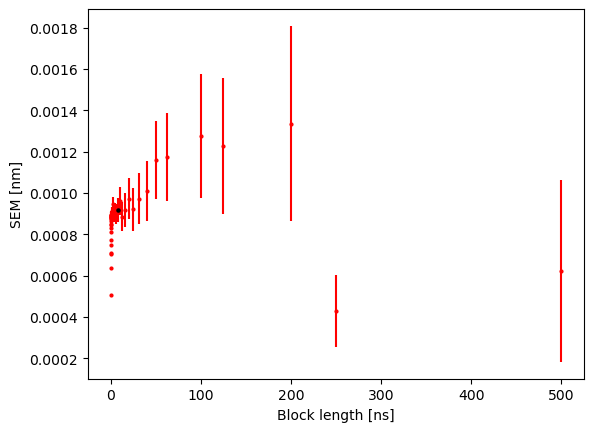

DSS1


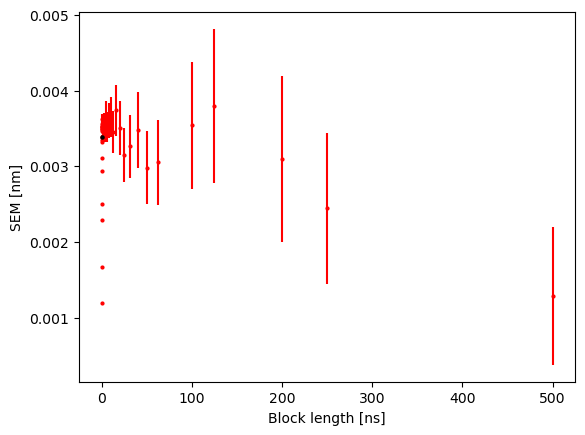

Sic1


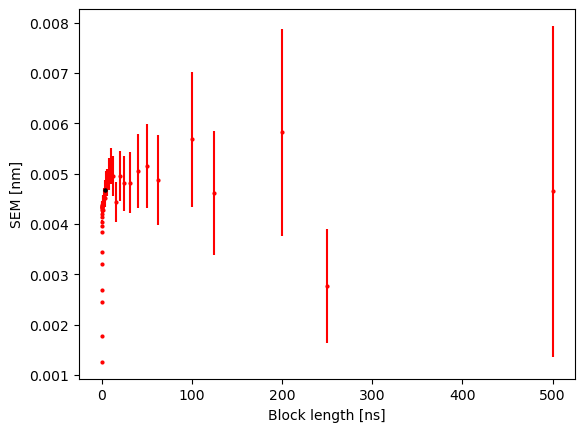

ProTa


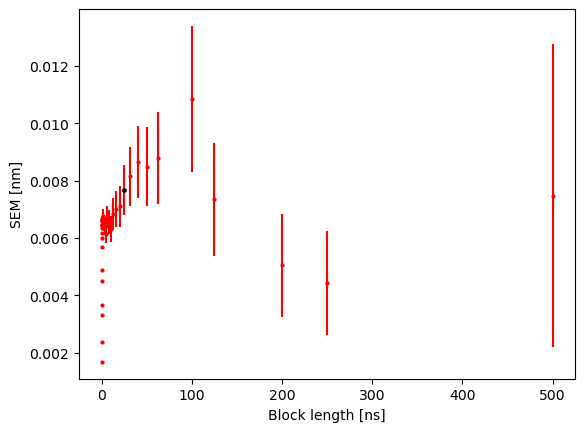

NHE6cmdd


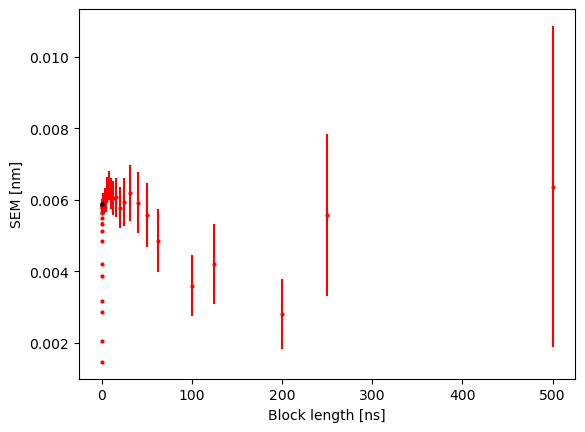

A1


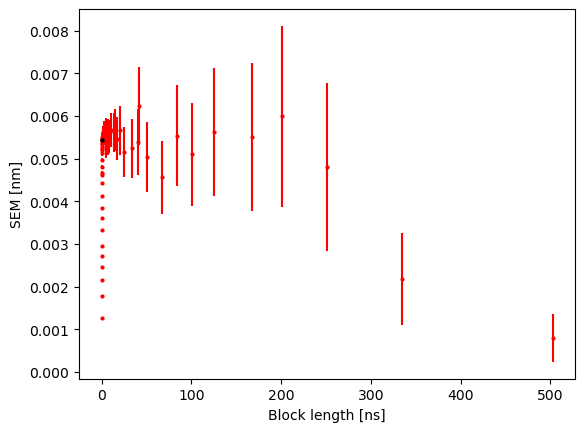

aSyn


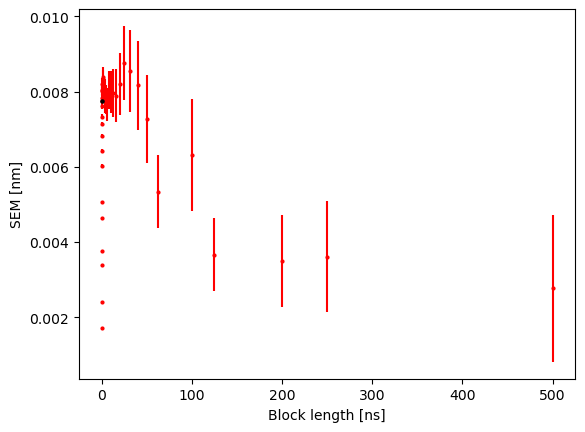

ANAC046


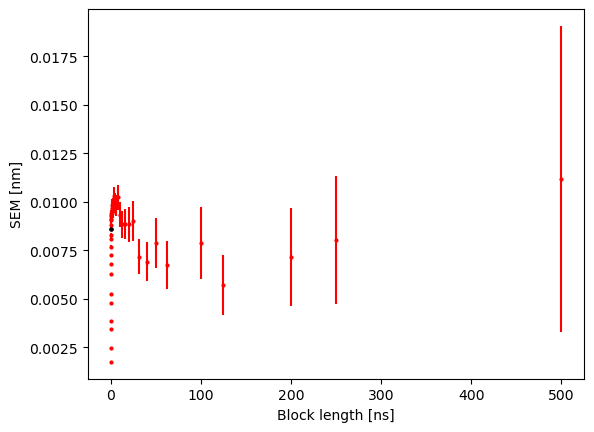

GHR-ICD


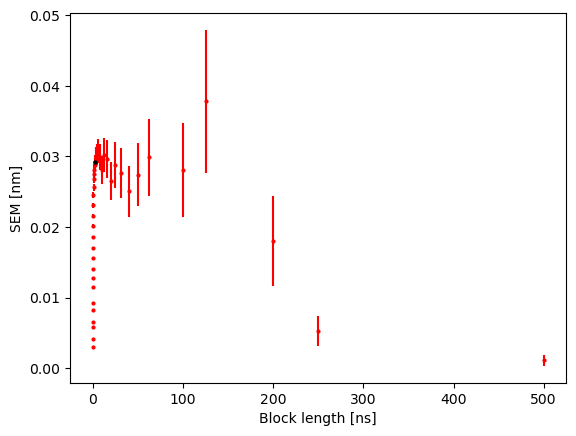

Tau


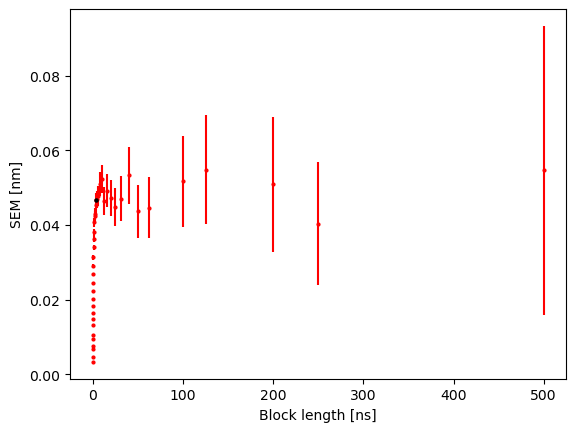

In [28]:
for k,v in rg_ca.items():
    print(k)
    autoblock(v)

In [29]:
asph = {}
acyl = {}
rel_shape_ani = {}
for p,t in traj.items():
    asph[p] = md.asphericity(t)
    acyl[p] = md.acylindricity(t)
    rel_shape_ani[p] = md.relative_shape_antisotropy(t)

In [349]:
rel_dev = abs( dataset.Rh - np.array([v[2] for x,v in Rh_Kirk.items()]) ) / dataset.Rh

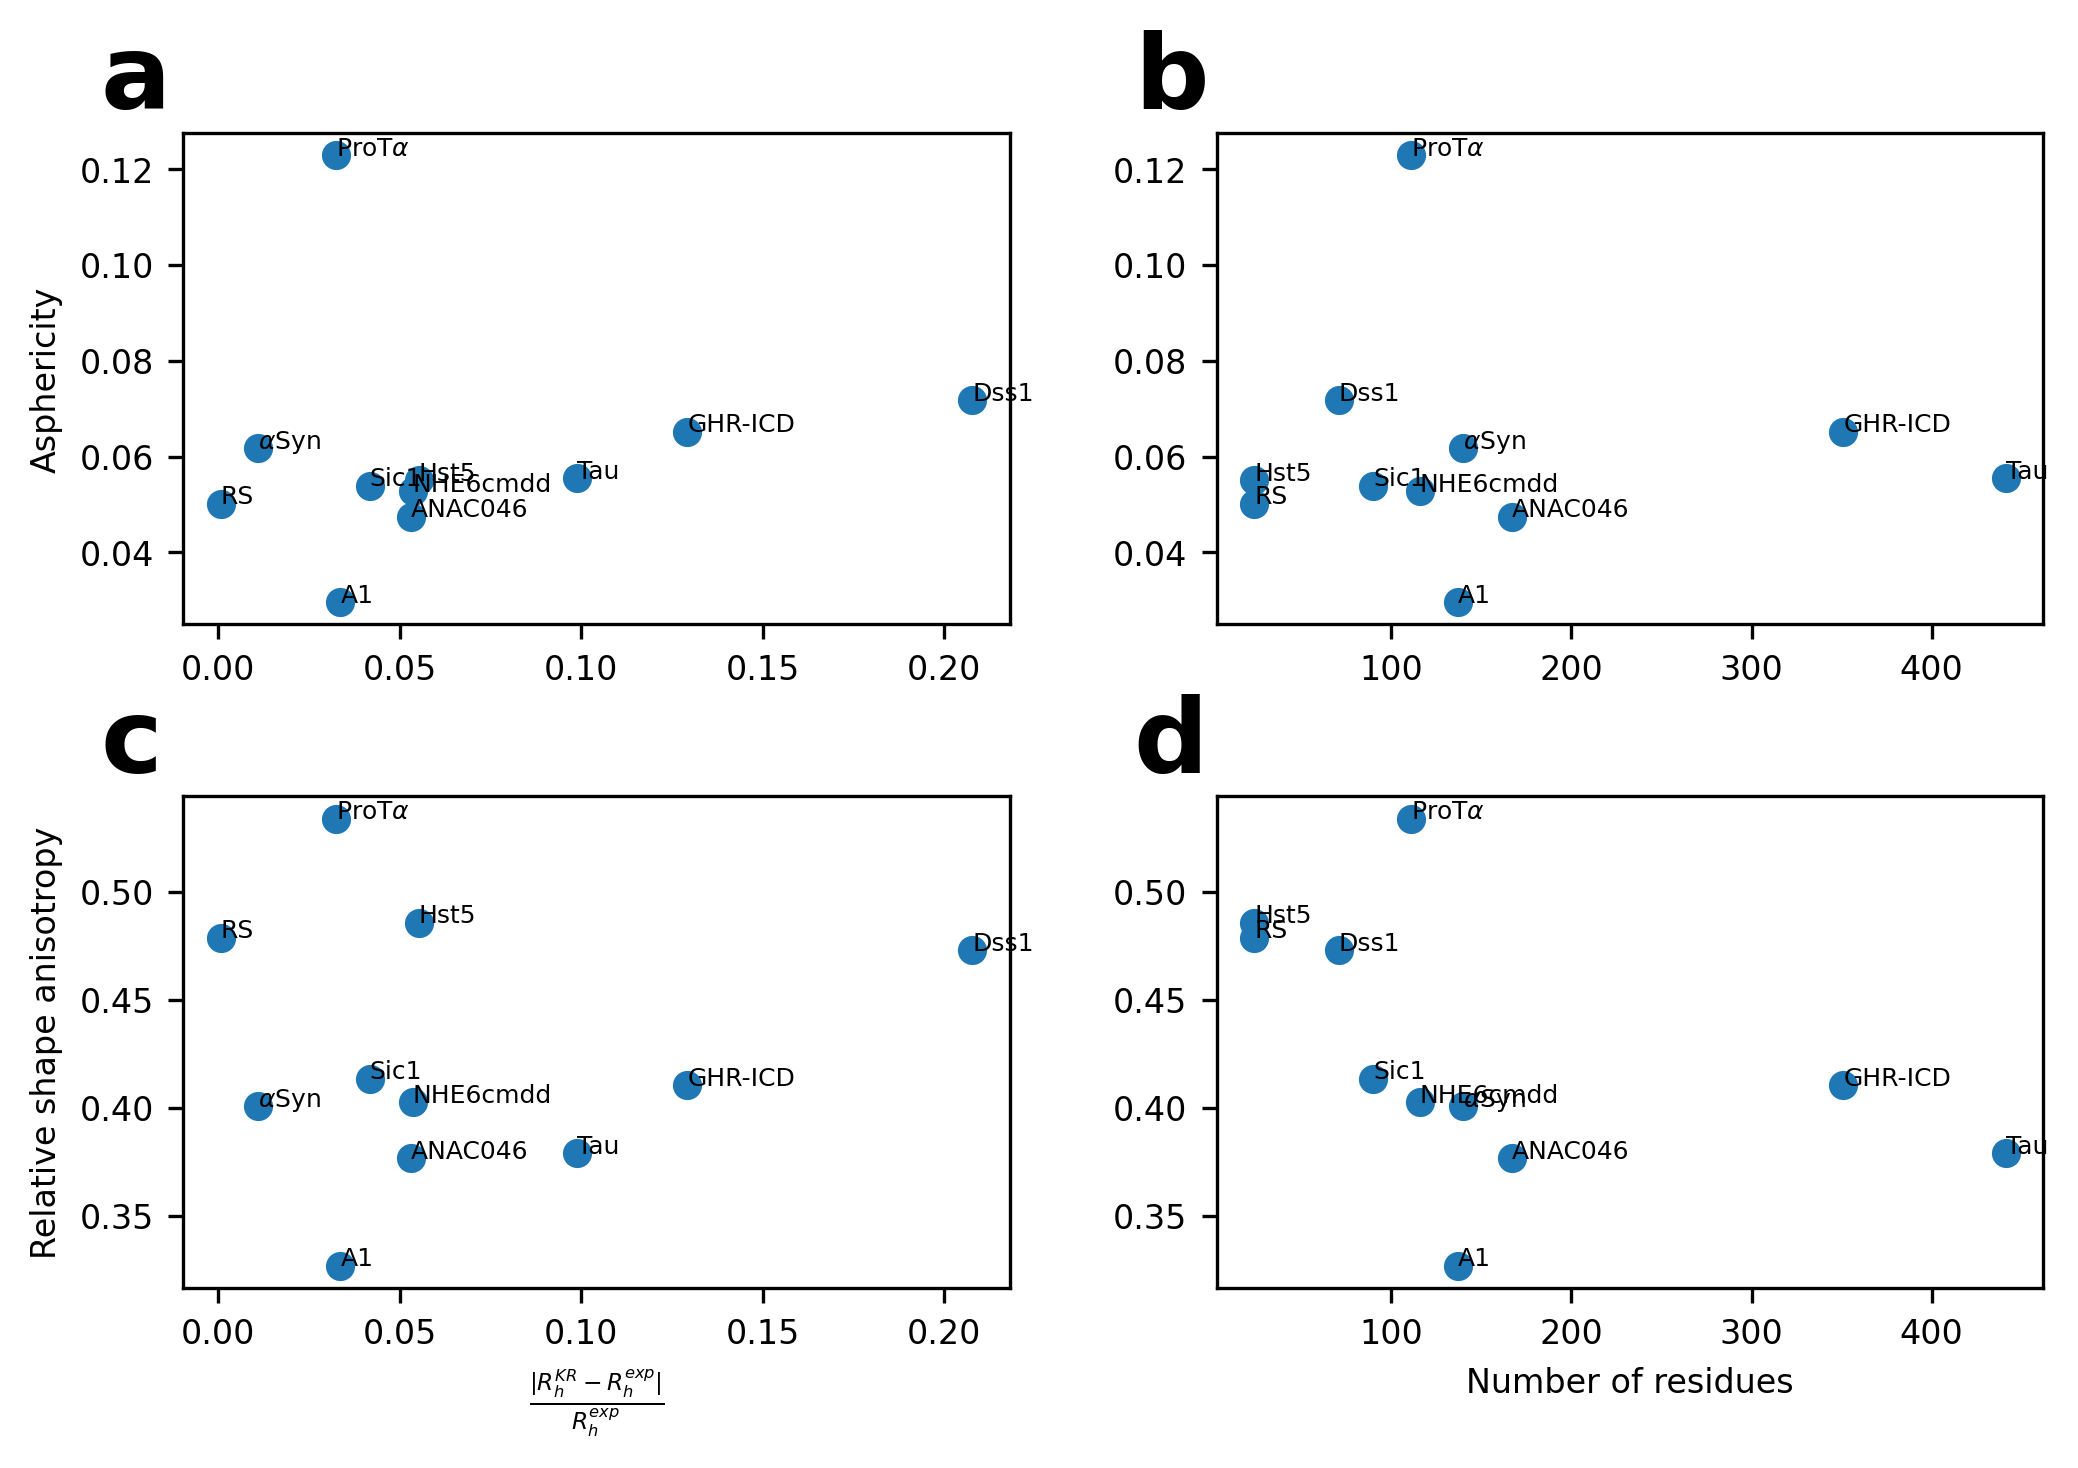

In [350]:
fig, axs = plt.subplots(2,2, figsize=(8,5), gridspec_kw={'hspace':0.35, 'wspace':0.25}, dpi=300, facecolor='w')

av = [asph[p].mean()/dataset.length[p] for p in dataset.index]
axs[0,0].scatter(rel_dev, av)
for i, txt in enumerate(dataset.index):
    axs[0,0].annotate(names_form[i], (rel_dev[i], av[i]), fontsize=6)
axs[0,0].set_ylabel('Asphericity')

axs[0,1].scatter(dataset.length, av)
for i, txt in enumerate(dataset.index):
    axs[0,1].annotate(names_form[i], (dataset.length[i], av[i]), fontsize=6)
    
av = [rel_shape_ani[p].mean() for p in dataset.index]
axs[1,0].scatter(rel_dev, av)
for i, txt in enumerate(dataset.index):
    axs[1,0].annotate(names_form[i], (rel_dev[i], av[i]), fontsize=6)

axs[1,1].scatter(dataset.length, av)
for i, txt in enumerate(dataset.index):
    axs[1,1].annotate(names_form[i], (dataset.length[i], av[i]), fontsize=6)
    
axs[1,0].set_xlabel(r'$\frac{|R_h^{KR}-R_h^{exp}|}{R_h^{exp}}$')
axs[1,1].set_xlabel('Number of residues')
axs[1,0].set_ylabel('Relative shape anisotropy')

for i,ax in enumerate(axs.flatten()):
    ax.text(-0.1,1.05, string.ascii_lowercase[i], fontsize=25, weight='bold', transform=ax.transAxes)

plt.savefig('shape.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

#### Subsampling: 1 frame every 10, resulting in a total of 20000 frames per simulation (i.e. frames taken every 50 ps)

In [50]:
times = np.arange(1000,200000,10)

In [1084]:
for p,t in traj.items():
    shutil.rmtree(folder+p+'/CG_frames')
    os.mkdir(folder+p+'/CG_frames')
    seq3 = [residues.three[x] for x in dataset.sequence[p]]
    t = fix_topology(t, seq3)
    for c,i in enumerate(times):
        t[i].save_pdb(folder+p+'/CG_frames/frame{}.pdb'.format(c))

### Analyse iBME(SAXS) results for M1

In [38]:
exp_saxs = {}

for p in dataset.index:
    exp_saxs[p] = np.loadtxt(p+'/bift_saxs.txt')
    if exp_saxs[p][...,0][-1] < 1:
        exp_saxs[p][...,0] *= 10

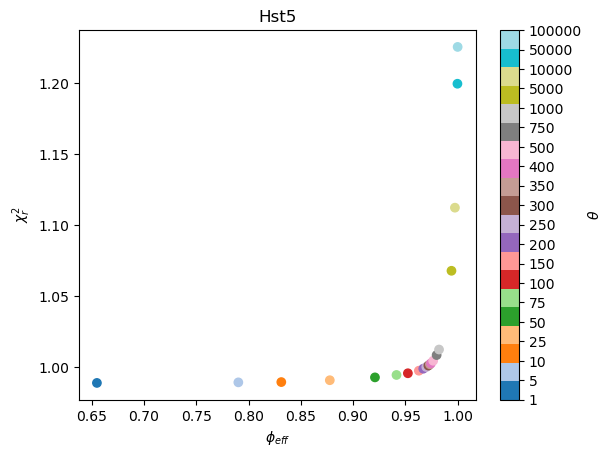

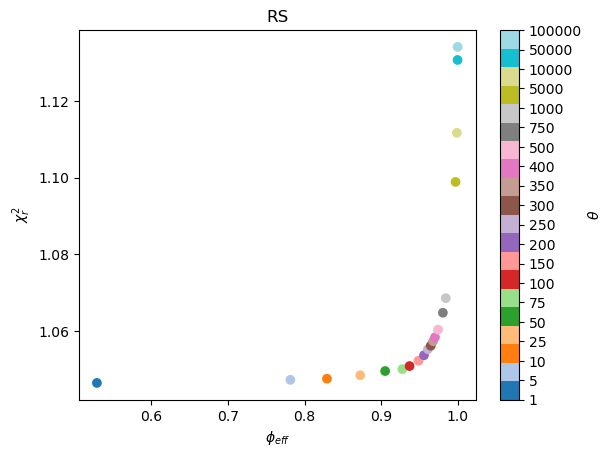

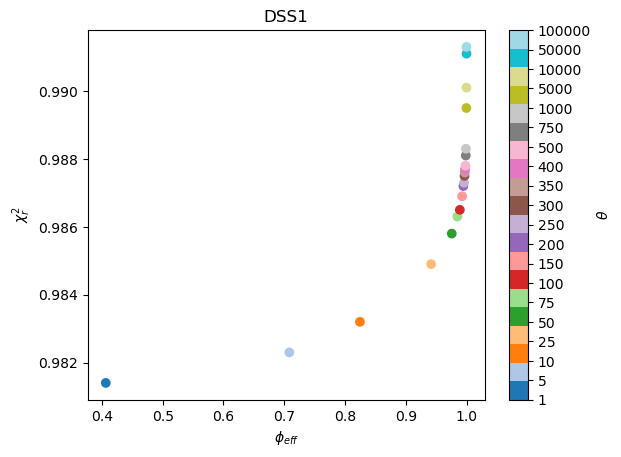

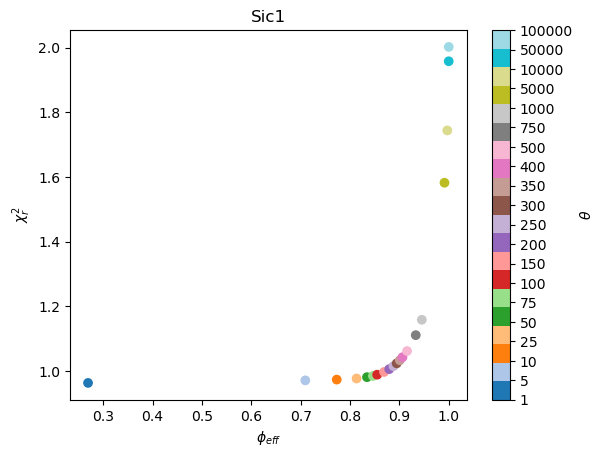

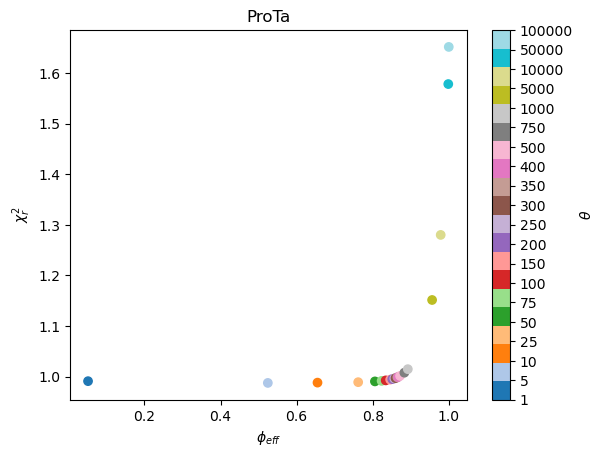

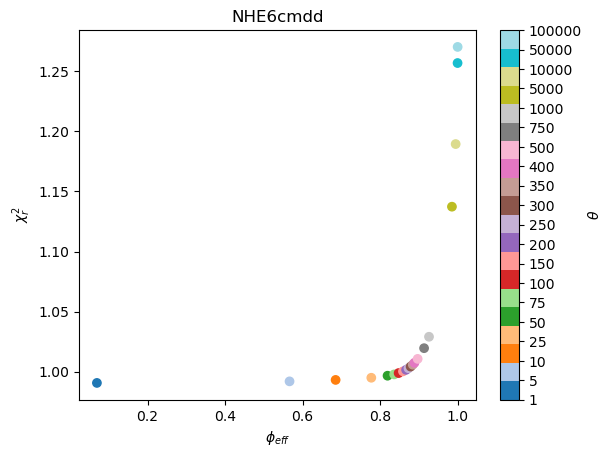

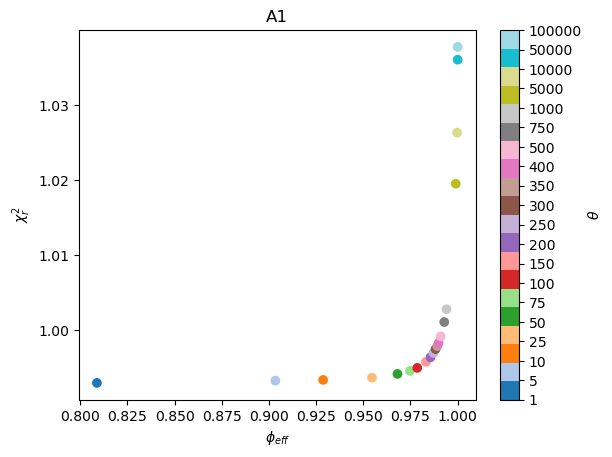

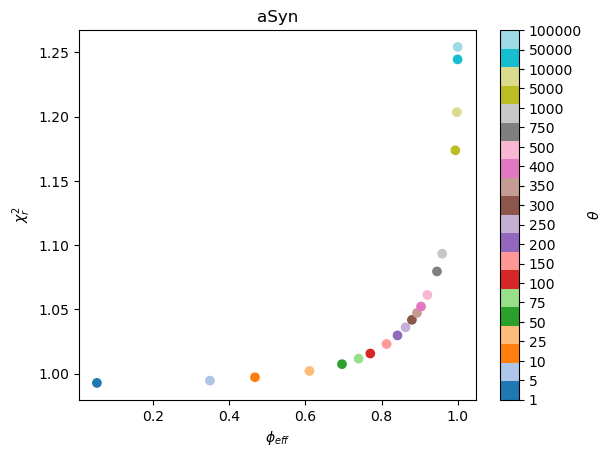

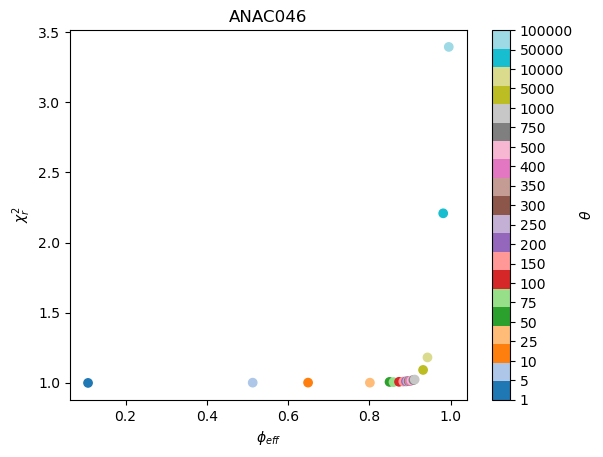

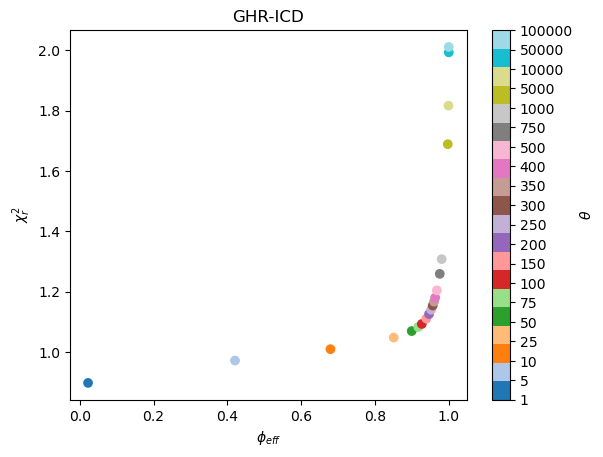

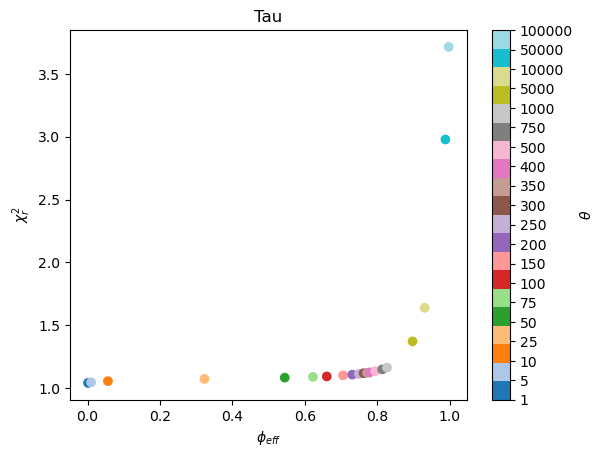

In [36]:
thetas = [ 1, 5, 10, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 500, 750, 1000, 5000, 10000, 50000, 100000  ]
BME_tscan_M1 = {}
for idp in dataset.index:
    BME_tscan_M1[idp] = []
    for t in thetas:
        f_ = list(filter(lambda x: x.startswith('t'+str(t)+'_ibme_'), os.listdir(idp+'/BME')))
        f_.sort( key=lambda x: int(x[:-4].split('_')[2]) )
        for l in open(idp+'/BME/'+f_[-1], 'r').readlines():
            if l.startswith('CHI2 after optimization:'):
                chi2 = float(l.split()[-1])
            elif l.startswith('Fraction of effective frames:'):
                phi = float(l.split()[-1])
        BME_tscan_M1[idp].append([t,chi2,phi])
    
    tscan = np.array(BME_tscan_M1[idp])
    #plt.fig = plt.figure(figsize=(3,2))
    plt.scatter(tscan[...,2], tscan[...,1], c=range(len(tscan)), cmap=plt.get_cmap('tab20'))
    cbar = plt.colorbar(ticks=range(len(tscan)), label=r'$\theta$', spacing='uniform')
    cbar.ax.set_yticklabels(thetas)
    plt.title(idp)
    plt.xlabel(r'$\phi_{eff}$')
    plt.ylabel(r'$\chi^2_r$')
    plt.show()

In [34]:
#Choice of thetas
theta_M1 ={
    'Hst5': 250,
    'RS': 150,
    'DSS1': 25,
    'Sic1': 200,
    'NHE6cmdd': 150,
    'A1':750,
    'aSyn': 100,
    'ANAC046': 1000,
    'GHR-ICD': 50,
    'Tau': 750,
    'ProTa': 500
}

In [495]:
weights_M1 = {}
calc_saxs_M1 = {}
for idp in dataset.index:
    f_ = list(filter(lambda x: x.startswith('t'+str(theta_M1[idp])+'_ibme_'), os.listdir(idp+'/BME')))
    f_.sort( key=lambda x: int(x[:-4].split('_')[2]) )
    conv_ndx = f_[-1][:-4].split('_')[2]
    weights_M1[idp] = np.loadtxt(idp+'/BME/t'+str(theta_M1[idp])+'_'+str(conv_ndx)+'.weights.dat')[...,1] 
    calc_saxs_M1[idp] = np.loadtxt(idp+'/BME/t'+str(theta_M1[idp])+'_'+str(conv_ndx)+'.calc.dat')[...,1:]
    np.savetxt('w_{}.dat'.format(idp),weights_M1[idp])

In [496]:
dataset

Rh  Rh_err                                           sequence  \
name                                                                         
Hst5      1.275   0.024                           DSHAKRHHGYKRKFHEKHHSHRGY   
RS        1.190   0.010                           GAMGPSYGRSRSRSRSRSRSRSRS   
DSS1      1.700   0.060  MSRAALPSLENLEDDDEFEDFATENWPMKDTELDTGDDTLWENNWD...   
Sic1      2.150   0.110  MTPSTPPRSRGTRYLAQPSGNTSSSALMQGQKTPQKPSQNLVPVTP...   
ProTa     2.890   0.080  GPSDAAVDTSSEITTKDLKEKKEVVEEAENGRDAPANGNANEENGE...   
NHE6cmdd  2.670   0.020  GPPLTTTLPACCGPIARCLTSPQAYENQEQLKDDDSDLILNDGDIS...   
A1        2.290   0.060  GSMASASSSQRGRSGSGNFGGGRGGGFGGNDNFGRGGNFSGRGGFG...   
aSyn      2.790   0.030  MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...   
ANAC046   3.040   0.010  NAPSTTITTTKQLSRIDSLDNIDHLLDFSSLPPLIDPGFLGQPGPS...   
GHR-ICD   5.080   0.020  SKQQRIKMLILPPVPVPKIKGIDPDLLKEGKLEEVNTILAIHDSYK...   
Tau       5.400   0.200  MAEPRQEFEVMEDHAGTYGLGDRKDQGGYTMHQDQEGDTDAGLKES...   

          length  Rh_rel_err  
name                          
Hst5          24    0.026668  
RS            24    0.024890  
DSS1          71    0.035557  
Sic1          90    0.044969  
ProTa        111    0.060446  
NHE6cmdd     116    0.055845  
A1           137    0.047897  
aSyn         140    0.058355  
ANAC046      167    0.063584  
GHR-ICD      351    0.106252  
Tau          441    0.112945

In [39]:
chi2saxs_M1 = []
for i in dataset.index:
    chi2saxs_M1.append(np.array(BME_tscan_M1[i])[...,1][np.array(BME_tscan_M1[i])[...,0] == theta_M1[i]][0])

calc_saxs_ini_M1 = {}
chi2saxs_ini_M1 = []
for i in dataset.index:
    calc = np.average(calc_saxs_M1[i], axis=0)

    exp_i = exp_saxs[i][...,1]
    exp_err = exp_saxs[i][...,2]
    wlr = 1/(exp_err**2)

    model = LinearRegression()
    model.fit(calc.reshape(-1,1),exp_i,wlr)
    a = model.coef_[0]
    b = model.intercept_

    calc = a*calc+b
    calc_saxs_ini_M1[i] = calc
    
    N = len(calc)
    chi2 = ((exp_i - calc)**2 / exp_err**2).sum()
    chi2red = chi2/N
    chi2saxs_ini_M1.append(chi2red)

### Analyse iBME(SAXS) results for FM

In [40]:
BME_tscan_FM = {}
for idp in dataset.index:
    BME_tscan_FM[idp] = []
    for t in thetas:
        f_ = list(filter(lambda x: x.startswith('t'+str(t)+'_ibme_'), os.listdir('FM_old/'+idp+'/BME')))
        f_.sort( key=lambda x: int(x[:-4].split('_')[2]) )
        for l in open('FM_old/'+idp+'/BME/'+f_[-1], 'r').readlines():
            if l.startswith('CHI2 after optimization:'):
                chi2 = float(l.split()[-1])
            elif l.startswith('Fraction of effective frames:'):
                phi = float(l.split()[-1])
        BME_tscan_FM[idp].append([t,chi2,phi])

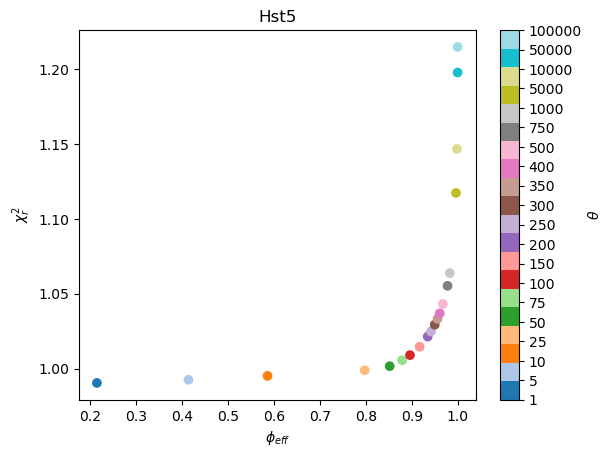

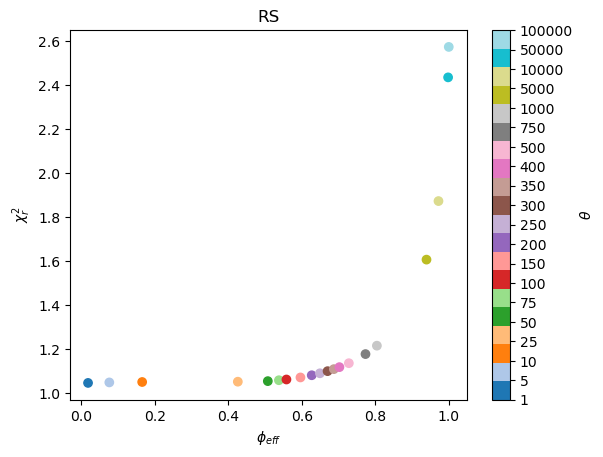

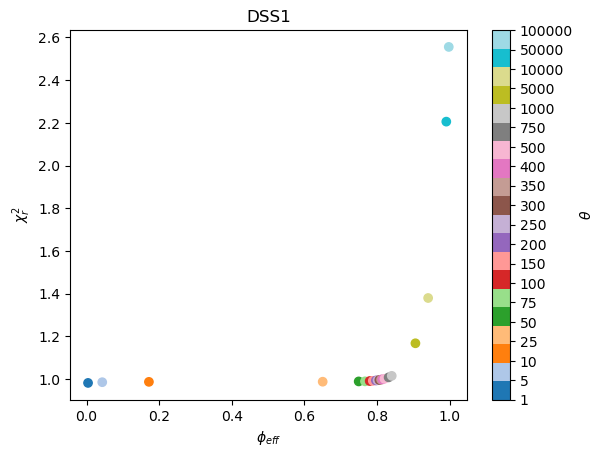

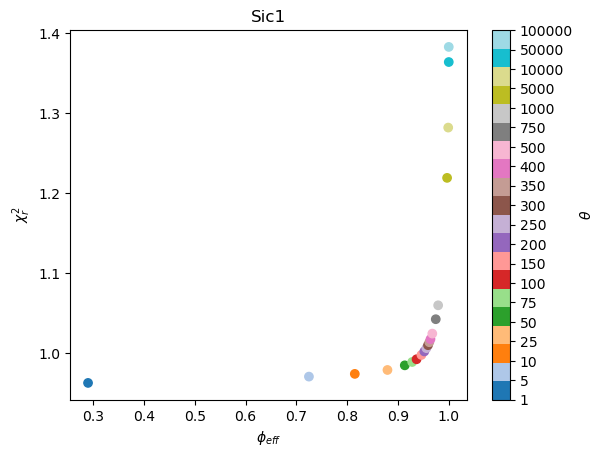

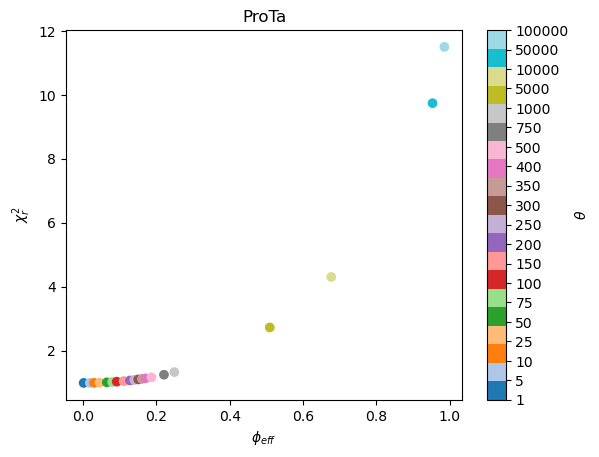

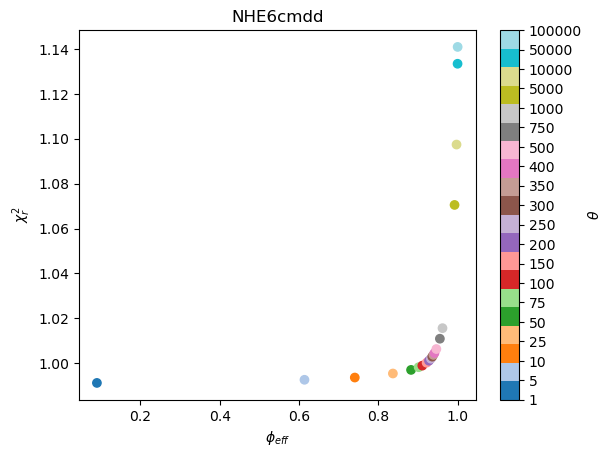

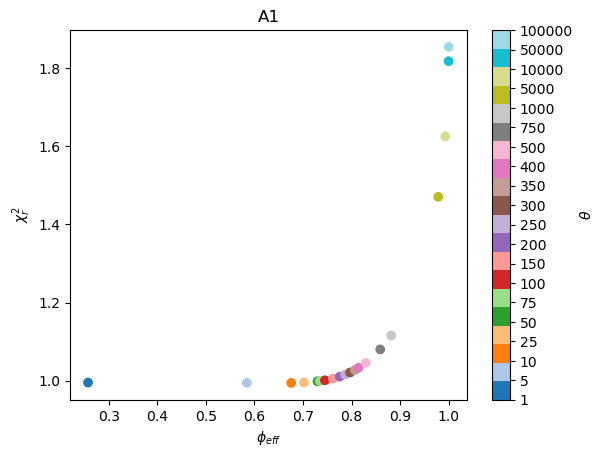

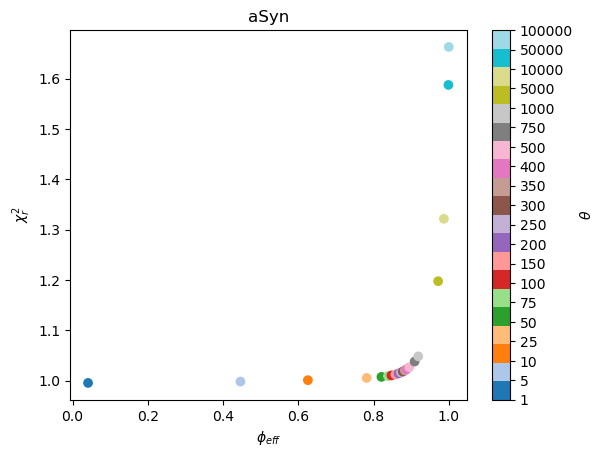

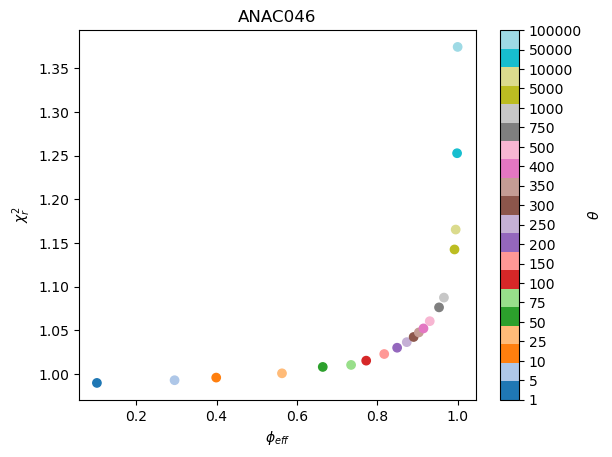

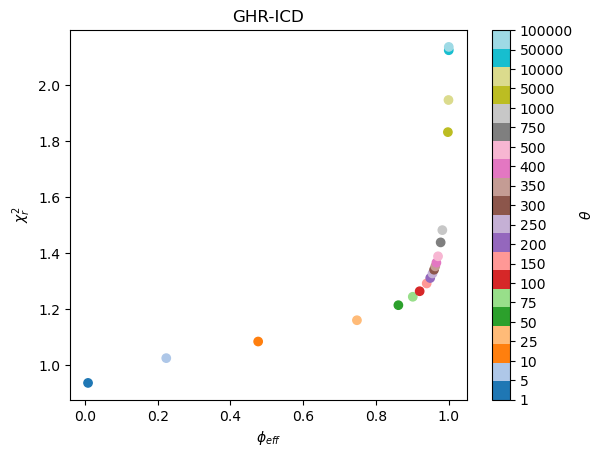

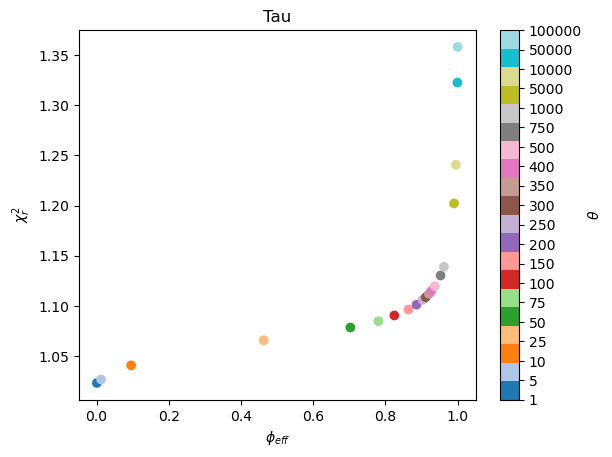

In [41]:
for idp in dataset.index:
    tscan = np.array(BME_tscan_FM[idp])
#    plt.fig = plt.figure(dpi=300)
    plt.scatter(tscan[...,2], tscan[...,1], c=range(len(tscan)), cmap=plt.get_cmap('tab20'))
    cbar = plt.colorbar(ticks=range(len(tscan)), label=r'$\theta$', spacing='uniform')
    cbar.ax.set_yticklabels(thetas)
    plt.title(idp)
    plt.xlabel(r'$\phi_{eff}$')
    plt.ylabel(r'$\chi^2_r$')
    plt.show()

In [45]:
theta_FM = {
    'Hst5': 50,
    'RS': 500,
    'Sic1': 200,
    'NHE6cmdd': 150,
    'aSyn': 150,
    'ANAC046': 150,
    'GHR-ICD': 75,
    'Tau': 150,
    'DSS1': 500,
    'ProTa': 5000,
    'A1': 100
}

In [46]:
weights_FM = {}
calc_saxs_FM = {}
for idp in dataset.index:
    f_ = list(filter(lambda x: x.startswith('t'+str(theta_FM[idp])+'_ibme_'), os.listdir('FM_old/'+idp+'/BME')))
    f_.sort( key=lambda x: int(x[:-4].split('_')[2]) )
    conv_ndx = f_[-1][:-4].split('_')[2]
    weights_FM[idp] = np.loadtxt('FM_old/'+idp+'/BME/t'+str(theta_FM[idp])+'_'+str(conv_ndx)+'.weights.dat')[...,1]  
    calc_saxs_FM[idp] = np.loadtxt('FM_old/'+idp+'/BME/t'+str(theta_FM[idp])+'_'+str(conv_ndx)+'.calc.dat')[...,1:]  

In [47]:
chi2saxs_FM = []
for i in dataset.index:
    chi2saxs_FM.append(np.array(BME_tscan_FM[i])[...,1][np.array(BME_tscan_FM[i])[...,0] == theta_FM[i]][0])

calc_saxs_ini_FM = {}
chi2saxs_ini_FM = []
for i in dataset.index:
    calc = np.average(calc_saxs_FM[i], axis=0)

    exp_i = exp_saxs[i][...,1]
    exp_err = exp_saxs[i][...,2]
    wlr = 1/(exp_err**2)

    model = LinearRegression()
    model.fit(calc.reshape(-1,1),exp_i,wlr)
    a = model.coef_[0]
    b = model.intercept_

    calc = a*calc+b
    calc_saxs_ini_FM[i] = calc
    
    N = len(calc)
    chi2 = ((exp_i - calc)**2 / exp_err**2).sum()
    chi2red = chi2/N
    chi2saxs_ini_FM.append(chi2red)

### Radius of gyration from multiple approaches

In [609]:
def extended_guinier_analysis(saxs, N):
    N = N-1
    gamma = 1.1615
    b = 0.55 #nm
    
    nu_guess = 0.5
    I0_guess = np.average(saxs[...,1][:10])
    
    def f(q, nu, I0):
        rg = np.sqrt( (gamma*(gamma+1)) / (2*(gamma+2*nu)*(gamma+2*nu+1)) ) * b * (N**nu)
        fitI = -1/3 * (q**2) * (rg**2) + 0.0479*(nu - 0.212)*(q**4)*(rg**4)
        fitI = np.exp(fitI)*I0
        return fitI
    
    qmax = 0.3
    qmaxRg = 0
    while qmaxRg <= 2.0:
        ndx = np.where(saxs[...,0]<=qmax)
        q = saxs[...,0][ndx]
        Iexp = saxs[...,1][ndx]
        Ierr = saxs[...,2][ndx]
    
        nu, I0 = curve_fit(f, xdata=q, ydata=Iexp, sigma=Ierr, p0=[nu_guess, I0_guess])[0]
        rg = np.sqrt( (gamma*(gamma+1))/(2*(gamma+2*nu)*(gamma+2*nu+1)) ) * b * (N**nu)
        qmaxRg = qmax*rg
        print ('qmax: {:f} nm; Rg: {:f} nm; qmax*Rg: {:f}'.format(qmax, rg, qmaxRg))
        
        if qmaxRg < 2.:
            Rg = rg
            NU = nu
        qmax += 0.05
        
    return Rg, NU

In [605]:
guinier = [1.34, 1.26, 2.49, 2.86, 3.68, 3.23, 2.55, 3.56, 3.61, 6.03, 6.36]
guinier_std = [0.05, 0.075, 0.13, 0.14, 0.16, 0.2, 0.15, 0.036, 0.3, 0.47, 0.52]
guinier_ext_rg = []
guinier_ext_nu = []
mff_rg = [1.39, 1.36, 2.64, 3.06, 3.94, 3.40, 2.73, 3.68, 3.77, 5.96, 6.66]
mff_rg_std = [0.01, 0.007, 0.004, 0.015, 0.007, 0.014, 0.016, 0.009, 0.004, 0.038, 0.036]
mff_nu = [0.50, 0.60, 0.57, 0.58, 0.59, 0.55, 0.447, 0.59, 0.58, 0.56, 0.59]
mff_nu_std = [0.11, 0.037, 0.005, 0.009, 0.003, 0.007, 0.006, 0.003, 0.001, 0.003, 0.001]

In [610]:
for p in dataset.index:
    rg, nu = extended_guinier_analysis(saxs=exp_saxs[p],N=dataset.length[p])
    guinier_ext_rg.append(rg)
    guinier_ext_nu.append(nu)

qmax: 0.300000 nm; Rg: 1.289727 nm; qmax*Rg: 0.386918
qmax: 0.350000 nm; Rg: 1.388671 nm; qmax*Rg: 0.486035
qmax: 0.400000 nm; Rg: 1.354702 nm; qmax*Rg: 0.541881
qmax: 0.450000 nm; Rg: 1.310302 nm; qmax*Rg: 0.589636
qmax: 0.500000 nm; Rg: 1.325218 nm; qmax*Rg: 0.662609
qmax: 0.550000 nm; Rg: 1.372941 nm; qmax*Rg: 0.755117
qmax: 0.600000 nm; Rg: 1.405340 nm; qmax*Rg: 0.843204
qmax: 0.650000 nm; Rg: 1.417626 nm; qmax*Rg: 0.921457
qmax: 0.700000 nm; Rg: 1.430973 nm; qmax*Rg: 1.001681
qmax: 0.750000 nm; Rg: 1.425920 nm; qmax*Rg: 1.069440
qmax: 0.800000 nm; Rg: 1.413000 nm; qmax*Rg: 1.130400
qmax: 0.850000 nm; Rg: 1.409979 nm; qmax*Rg: 1.198482
qmax: 0.900000 nm; Rg: 1.411010 nm; qmax*Rg: 1.269909
qmax: 0.950000 nm; Rg: 1.404112 nm; qmax*Rg: 1.333906
qmax: 1.000000 nm; Rg: 1.401953 nm; qmax*Rg: 1.401953
qmax: 1.050000 nm; Rg: 1.397998 nm; qmax*Rg: 1.467898
qmax: 1.100000 nm; Rg: 1.395614 nm; qmax*Rg: 1.535176
qmax: 1.150000 nm; Rg: 1.391742 nm; qmax*Rg: 1.600503
qmax: 1.200000 nm; Rg: 1.389

In [618]:
sg = 3
d = {'$R_\text{g}$ (ATSAS)': ['{} $\pm$ {}'.format(np.around(guinier[x],sg), np.around(guinier_std[x],sg)) for x in range(11)],
     '$R_\text{g}$ (Extended Guinier analysis)': ['{}'.format(np.around(guinier_ext_rg[x],sg)) for x in range(11)],
     '$R_\text{g}$ (Molecular Form Factor)': ['{} $\pm$ {}'.format(np.around(mff_rg[x],sg), np.around(mff_rg_std[x],sg)) for x in range(11)],
     '$\nu$ (Extended Guinier analysis)': ['{}'.format(np.around(guinier_ext_nu[x],sg)) for x in range(11)],
     '$\nu$ (Molecular Form Factor)': ['{} $\pm$ {}'.format(np.around(mff_nu[x],sg), np.around(mff_nu_std[x],sg)) for x in range(11)],
     r'$\frac{R_\text{g} (ATSAS)}/R_{\text{h}}$' : ['{}'.format( np.around(guinier[x]/dataset.Rh.values[x],sg)) for x in range(11)]
    }
d = pd.DataFrame(data=d, index=dataset.index)
d.to_latex('rg.tex')

In [619]:
d

$R_\text{g}$ (ATSAS) $R_\text{g}$ (Extended Guinier analysis)  \
name                                                                     
Hst5          1.34 $\pm$ 0.05                                    1.378   
RS           1.26 $\pm$ 0.075                                    1.343   
DSS1          2.49 $\pm$ 0.13                                    2.603   
Sic1          2.86 $\pm$ 0.14                                    3.034   
ProTa         3.68 $\pm$ 0.16                                    3.949   
NHE6cmdd       3.23 $\pm$ 0.2                                    3.361   
A1            2.55 $\pm$ 0.15                                    2.605   
aSyn         3.56 $\pm$ 0.036                                    3.619   
ANAC046        3.61 $\pm$ 0.3                                    3.729   
GHR-ICD       6.03 $\pm$ 0.47                                    6.093   
Tau           6.36 $\pm$ 0.52                                    6.236   

         $R_\text{g}$ (Molecular Form Factor)  \
name                                            
Hst5                          1.39 $\pm$ 0.01   
RS                           1.36 $\pm$ 0.007   
DSS1                         2.64 $\pm$ 0.004   
Sic1                         3.06 $\pm$ 0.015   
ProTa                        3.94 $\pm$ 0.007   
NHE6cmdd                      3.4 $\pm$ 0.014   
A1                           2.73 $\pm$ 0.016   
aSyn                         3.68 $\pm$ 0.009   
ANAC046                      3.77 $\pm$ 0.004   
GHR-ICD                      5.96 $\pm$ 0.038   
Tau                          6.66 $\pm$ 0.036   

         $\nu$ (Extended Guinier analysis) $\nu$ (Molecular Form Factor)  \
name                                                                       
Hst5                                 0.583                0.5 $\pm$ 0.11   
RS                                   0.572               0.6 $\pm$ 0.037   
DSS1                                 0.579              0.57 $\pm$ 0.005   
Sic1                                 0.583              0.58 $\pm$ 0.009   
ProTa                                0.618              0.59 $\pm$ 0.003   
NHE6cmdd                             0.571              0.55 $\pm$ 0.007   
A1                                   0.487             0.447 $\pm$ 0.006   
aSyn                                 0.563              0.59 $\pm$ 0.003   
ANAC046                              0.547              0.58 $\pm$ 0.001   
GHR-ICD                              0.563              0.56 $\pm$ 0.003   
Tau                                  0.544              0.59 $\pm$ 0.001   

         $\frac{R_\text{g} (ATSAS)}/R_{\text{h}}$  
name                                               
Hst5                                        1.051  
RS                                          1.059  
DSS1                                        1.465  
Sic1                                         1.33  
ProTa                                       1.273  
NHE6cmdd                                     1.21  
A1                                          1.114  
aSyn                                        1.276  
ANAC046                                     1.188  
GHR-ICD                                     1.187  
Tau                                         1.178

### Comparing FM and M1 ensembles

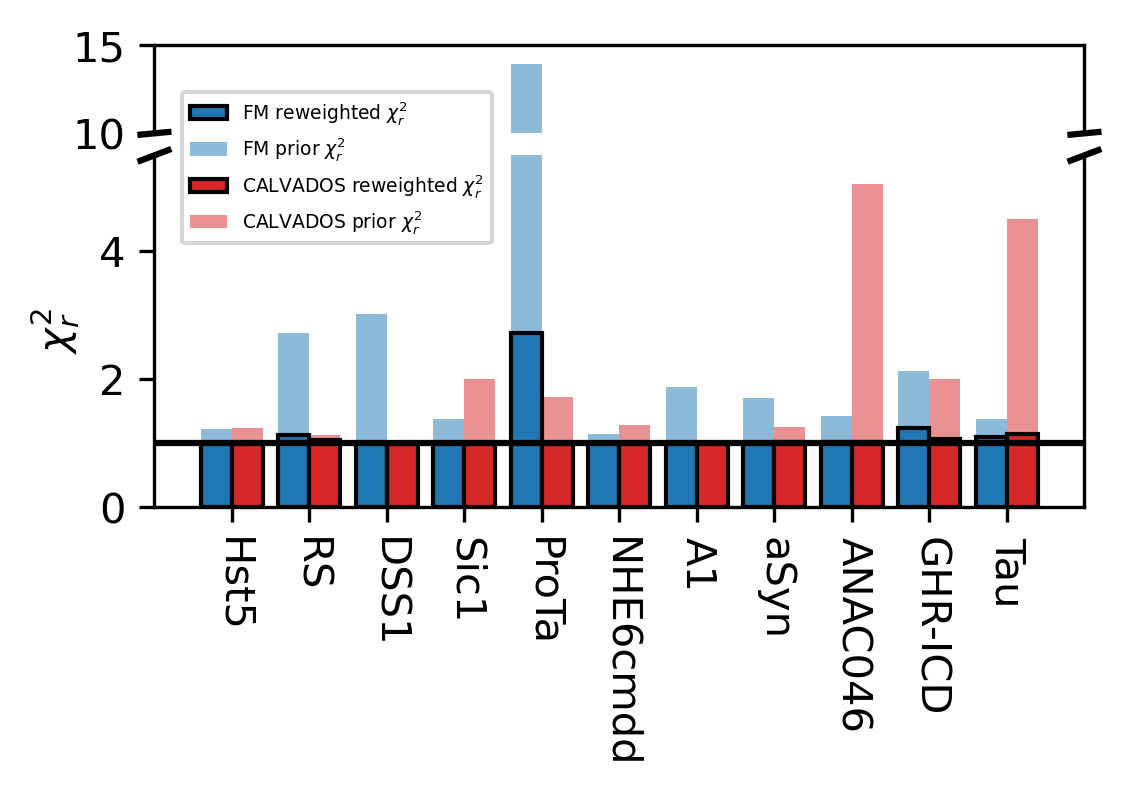

In [56]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(4, 2), dpi=300, gridspec_kw={'height_ratios': [1,4], 'hspace':0.1}, facecolor='w')
for ax in axs:
    ax.bar(np.arange(11)-0.2, chi2saxs_FM,zorder=100, label=r'FM reweighted $\chi^2_r$', edgecolor='k', width=0.4,color=c[0])
    ax.bar(np.arange(11)-0.2, chi2saxs_ini_FM, label=r'FM prior $\chi^2_r$', width=0.4,color=c[0],alpha=0.5)

    ax.bar(np.arange(11)+0.2, chi2saxs_M1,zorder=100, label=r'CALVADOS reweighted $\chi^2_r$', edgecolor='k', width=0.4,color=c[3])
    ax.bar(np.arange(11)+0.2, chi2saxs_ini_M1, color=c[3],alpha=0.5, label=r'CALVADOS prior $\chi^2_r$', width=0.4)
    
axs[0].set_ylim(10, 15)
axs[1].set_ylim(0, 5.5)
axs[0].spines['bottom'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
axs[0].tick_params(labeltop=False)  # don't put tick labels at the top
axs[1].xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=axs[0].transAxes, color='k', clip_on=False)
axs[0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
axs[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=axs[1].transAxes)  # switch to the bottom axes
axs[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
axs[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.xticks(ticks=range(11),labels=dataset.index,rotation=-90)
plt.hlines(1,-1,12,color='k',zorder=200)
plt.xlim(-1,11)
plt.ylim(0,5.5)
plt.ylabel(r'$\chi^2_r$')
axs[1].legend(fontsize=4.5, loc=(0.03,0.75))
#plt.tight_layout()
plt.savefig('bar_chi2.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

In [ ]:
Rg_Ca_M1 = {}
for p in dataset.index:
    Rg_Ca_M1[p] = []
    for i in range(0,20000):
        conf = md.load_pdb('/storage1/francesco/PROJECTS/ENSEMBLES/TSCL-M1/'+p+'/CG_frames/frame{}.pdb'.format(i))
        Rg_Ca_M1[p].append( md.compute_rg(conf)[0] )

In [71]:
FM_ens_size = {
    'Hst5': 10000,
    'RS': 10000,
    'DSS1': 15000,
    'Sic1': 15000,
    'ProTa': 15000,
    'NHE6cmdd': 15000,
    'aSyn': 20000,
    'ANAC046': 20000,
    'GHR-ICD': 25000,
    'Tau': 30000,
    'A1': 20000
}

In [ ]:
Rg_Ca_FM = {}
for p in dataset.index:
    Rg_Ca_FM[p] = []
    for i in range(0, FM_ens_size[p]):
        conf = md.load_pdb('/storage1/francesco/PROJECTS/ENSEMBLES/'+p+'/FM/frame{}.pdb'.format(i))
        conf = conf.atom_slice(conf.top.select('name CA'),inplace=True)
        Rg_Ca_FM[p].append( md.compute_rg(conf)[0] )

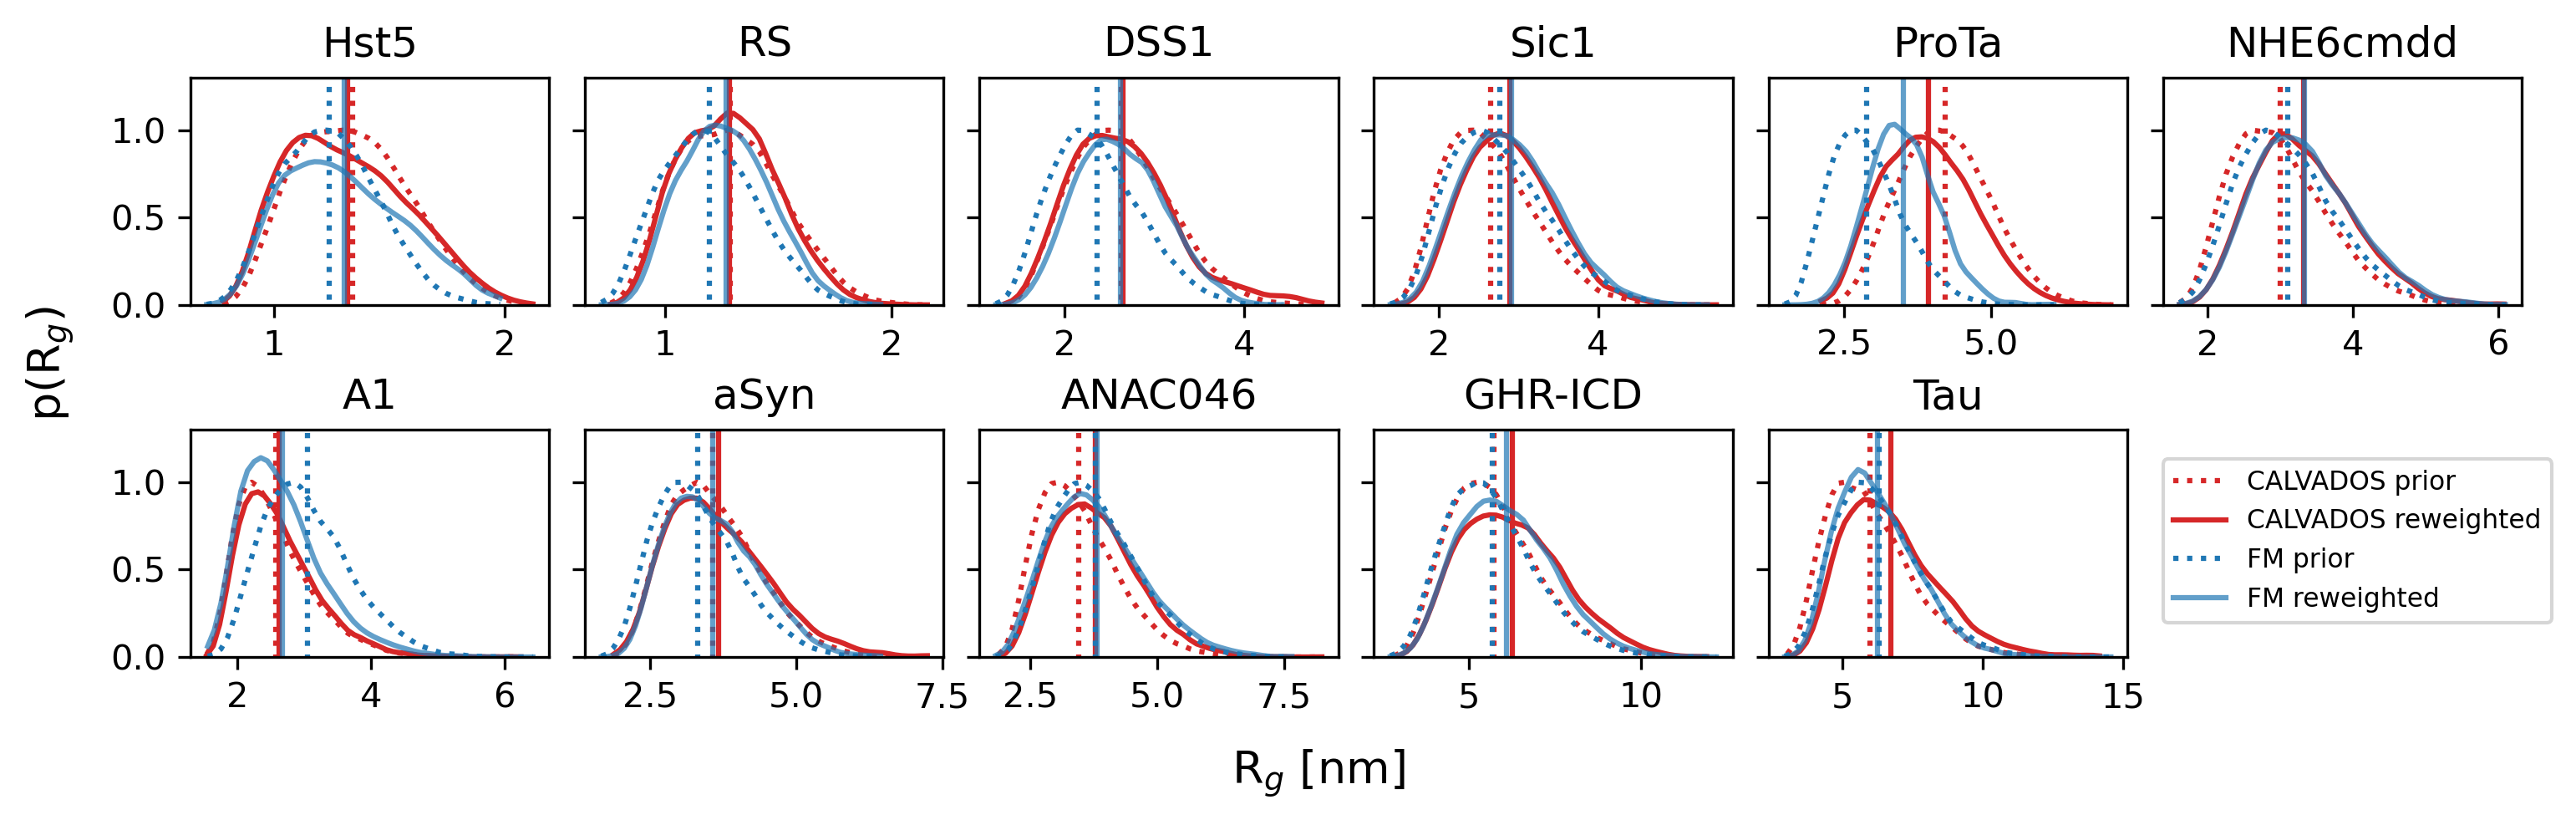

In [158]:
fig, axs = plt.subplots(2, 6, figsize=(12,3), facecolor='w', dpi=300,sharey=True)

plt.subplots_adjust(wspace=0.1, 
                    hspace=0.55)

for p, ax in zip(dataset.index, axs.flatten()):
    stat_m1 = kde_rg( np.array(Rg_Ca_M1[p]) )
    stat_m1_rew = kde_rg(np.array(Rg_Ca_M1[p]), w=weights_M1[p])
    
    stat_fm = kde_rg( np.array(Rg_Ca_FM[p]) )
    stat_fm_rew = kde_rg(np.array(Rg_Ca_FM[p]), w=weights_FM[p])
    
    l0 = ax.plot(stat_m1[0], stat_m1[1]/stat_m1[1].max(), label='CALVADOS prior',color=c[3], ls='dotted')
    ax.vlines(stat_m1[2],-10,10,color=c[3], ls='dotted')
    l1 = ax.plot(stat_m1_rew[0], stat_m1_rew[1]/stat_m1[1].max(), label='CALVADOS reweighted',color=c[3])
    ax.vlines(stat_m1_rew[2],-10,10,color=c[3])
    
    l2 = ax.plot(stat_fm[0], stat_fm[1]/stat_fm[1].max(), label='FM prior',color=c[0], ls='dotted')
    ax.vlines(stat_fm[2],-10,10,color=c[0], ls='dotted')
    l3 = ax.plot(stat_fm_rew[0], stat_fm_rew[1]/stat_fm[1].max(), label='FM reweighted',color=c[0], alpha=0.7)
    ax.vlines(stat_fm_rew[2],-10,10,color=c[0], alpha=0.7)
    
    ax.set_title(p)
    #ax.set_ylim(0,np.max( [stat_m1[1].max(), stat_fm[1].max(), stat_m1_rew[1].max(), stat_fm_rew[1].max()])+0.15)
    ax.set_ylim(0,1.3)
    
#ax10.set_xlabel(r'R$_g$ [nm]',fontsize=15)
#ax5.set_ylabel(r'p(R$_g$)',fontsize=15)
fig.supxlabel(r'R$_g$ [nm]',fontsize=13,y=-0.08)
fig.supylabel(r'p(R$_g$)',fontsize=13, x=0.07)
axs[-1,-2].legend(fontsize=7.5, loc=(1.1,0.15))
axs[-1,-1].axis('off')

plt.savefig('rg_fm_m1.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

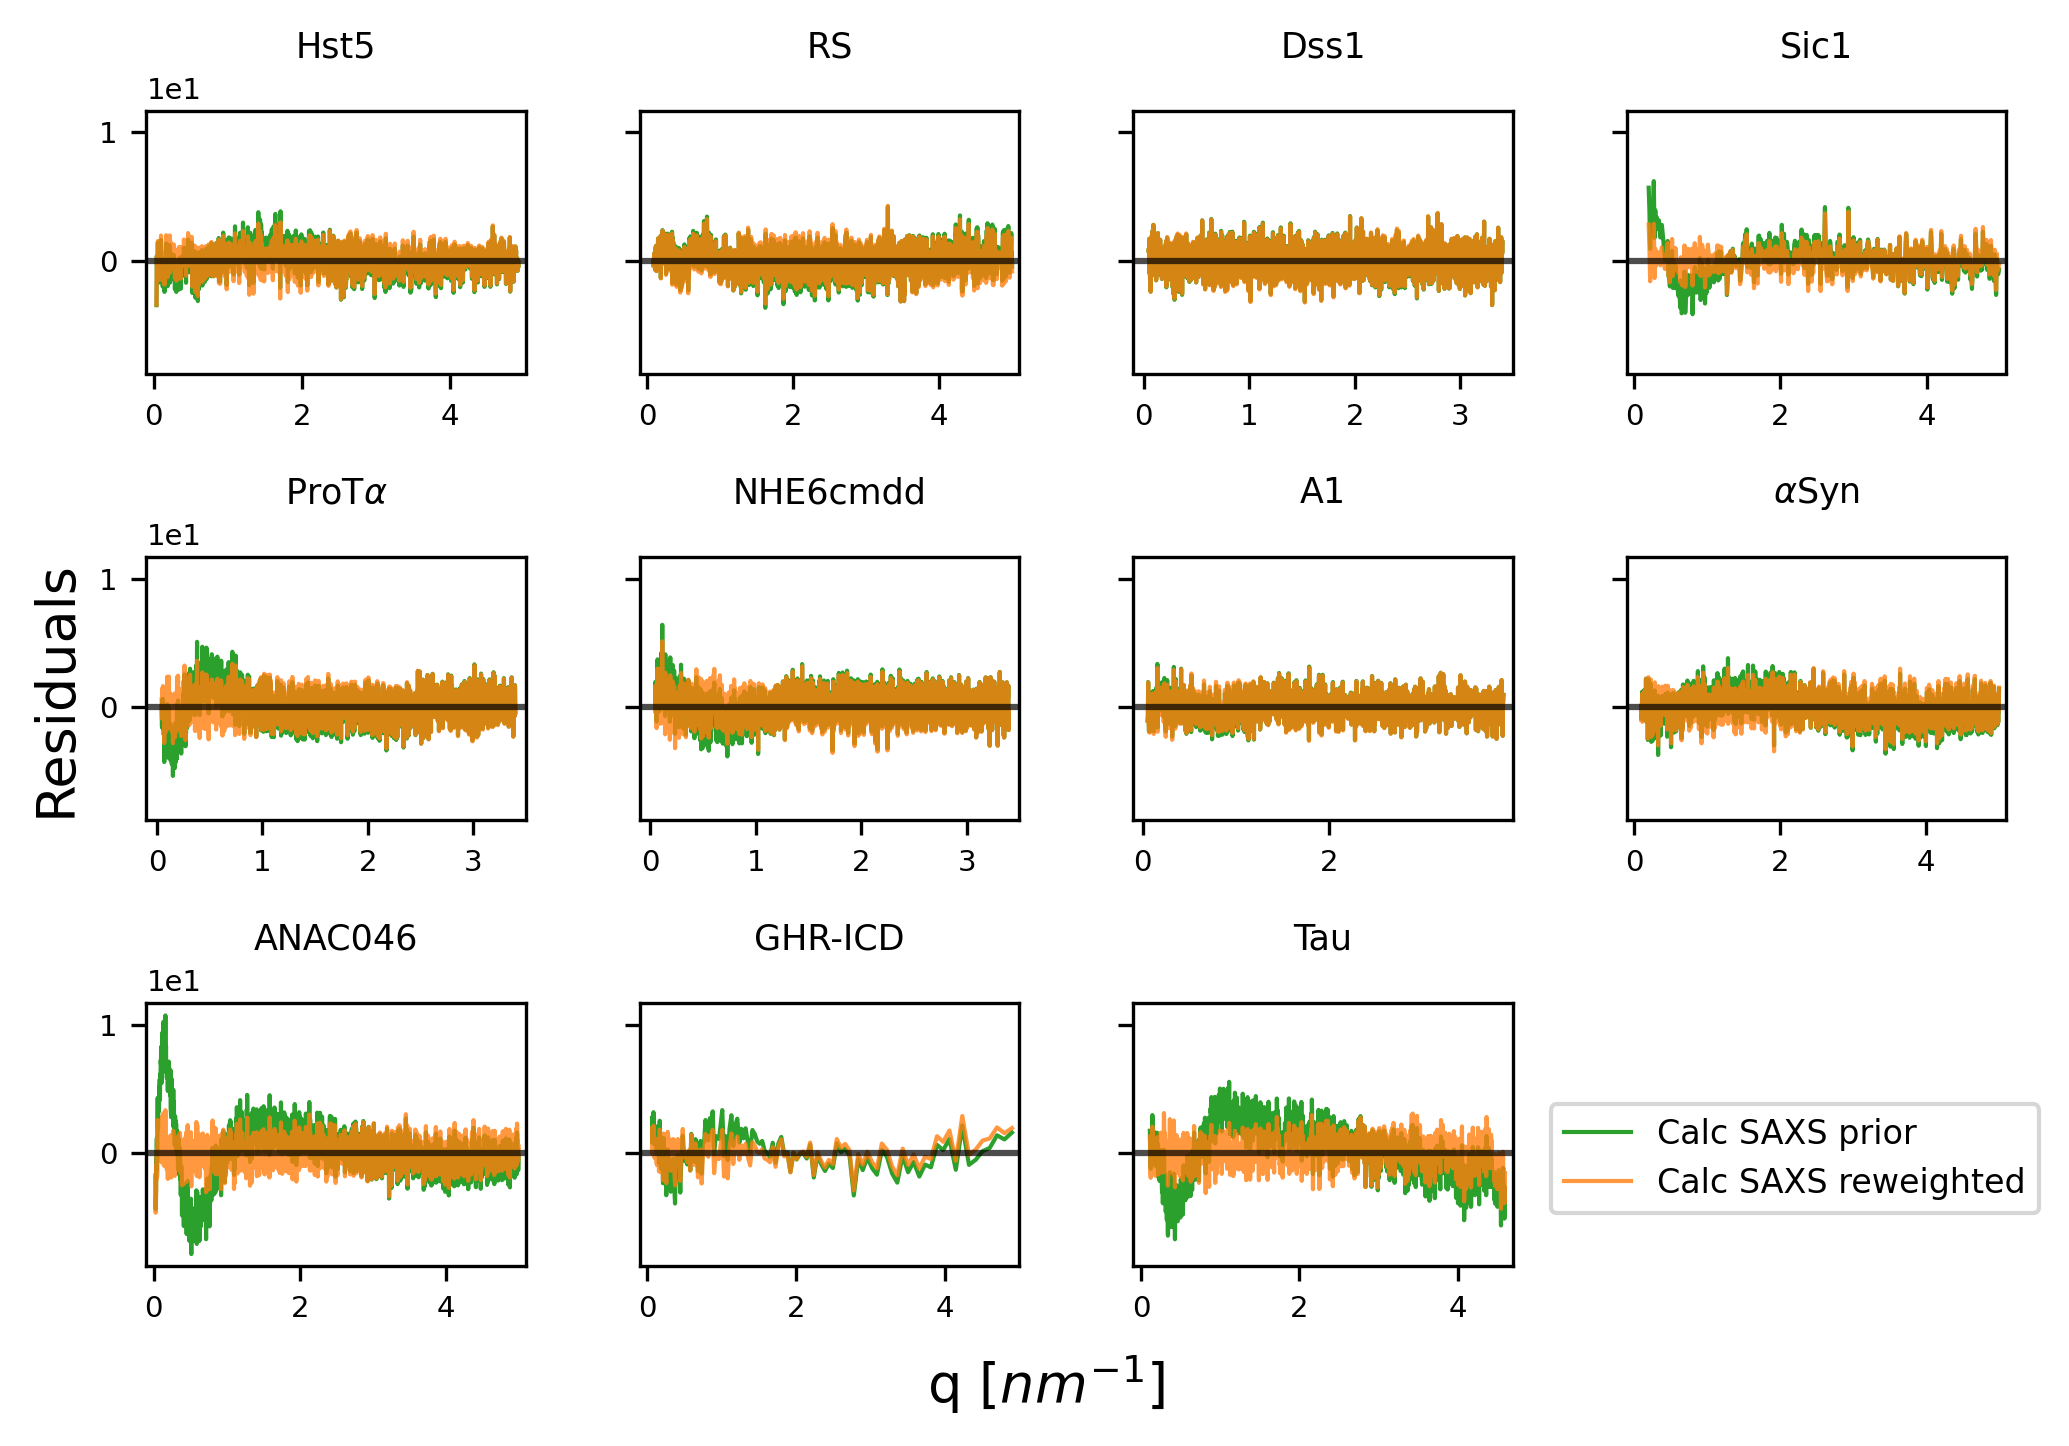

In [601]:
fig, axs = plt.subplots(3, 4, figsize=(8,5), facecolor='w', dpi=300,sharey=True)
for i, (p,ax) in enumerate(zip(dataset.index, axs.flatten())):
    ndx = exp_saxs[p][...,0] < 1.5
    
    q = exp_saxs[p][...,0]
    calc_i = np.average( calc_saxs_M1[p], weights=weights_M1[p], axis=0 )
    residual_rew = (exp_saxs[p][...,1] - calc_i) / exp_saxs[p][...,2]
    
    residual_ini = (exp_saxs[p][...,1] - calc_saxs_ini_M1[p]) / exp_saxs[p][...,2]

    ax.plot(q, residual_ini ,zorder=100, label='Calc SAXS prior',c=c[2], lw=1)
    ax.plot(q, residual_rew ,zorder=100, label='Calc SAXS reweighted',c=c[1], lw=1, alpha=0.8)
    
    ax.set_title(names_form[i],pad=13)
    ax.ticklabel_format(style='sci',scilimits=(0,0))
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.yaxis.get_offset_text().set_fontsize(7)
    #ax.set_xscale('log')
    ax.hlines(0,-0.1,np.max(q)+0.1,color='k',zorder=1000000000000,alpha=0.7)
    ax.set_xlim(-0.1,np.max(q)+0.1)
    
axs[-1,-1].axis('off')
axs.flatten()[4].set_ylabel('Residuals',fontsize=13)
fig.supxlabel(r'q [$nm^{-1}$]',fontsize=13)
axs.flatten()[-2].legend(fontsize=8, loc=(1.1,0.2))

plt.subplots_adjust(wspace=0.3, 
                    hspace=0.7)

plt.savefig('saxs_m1.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

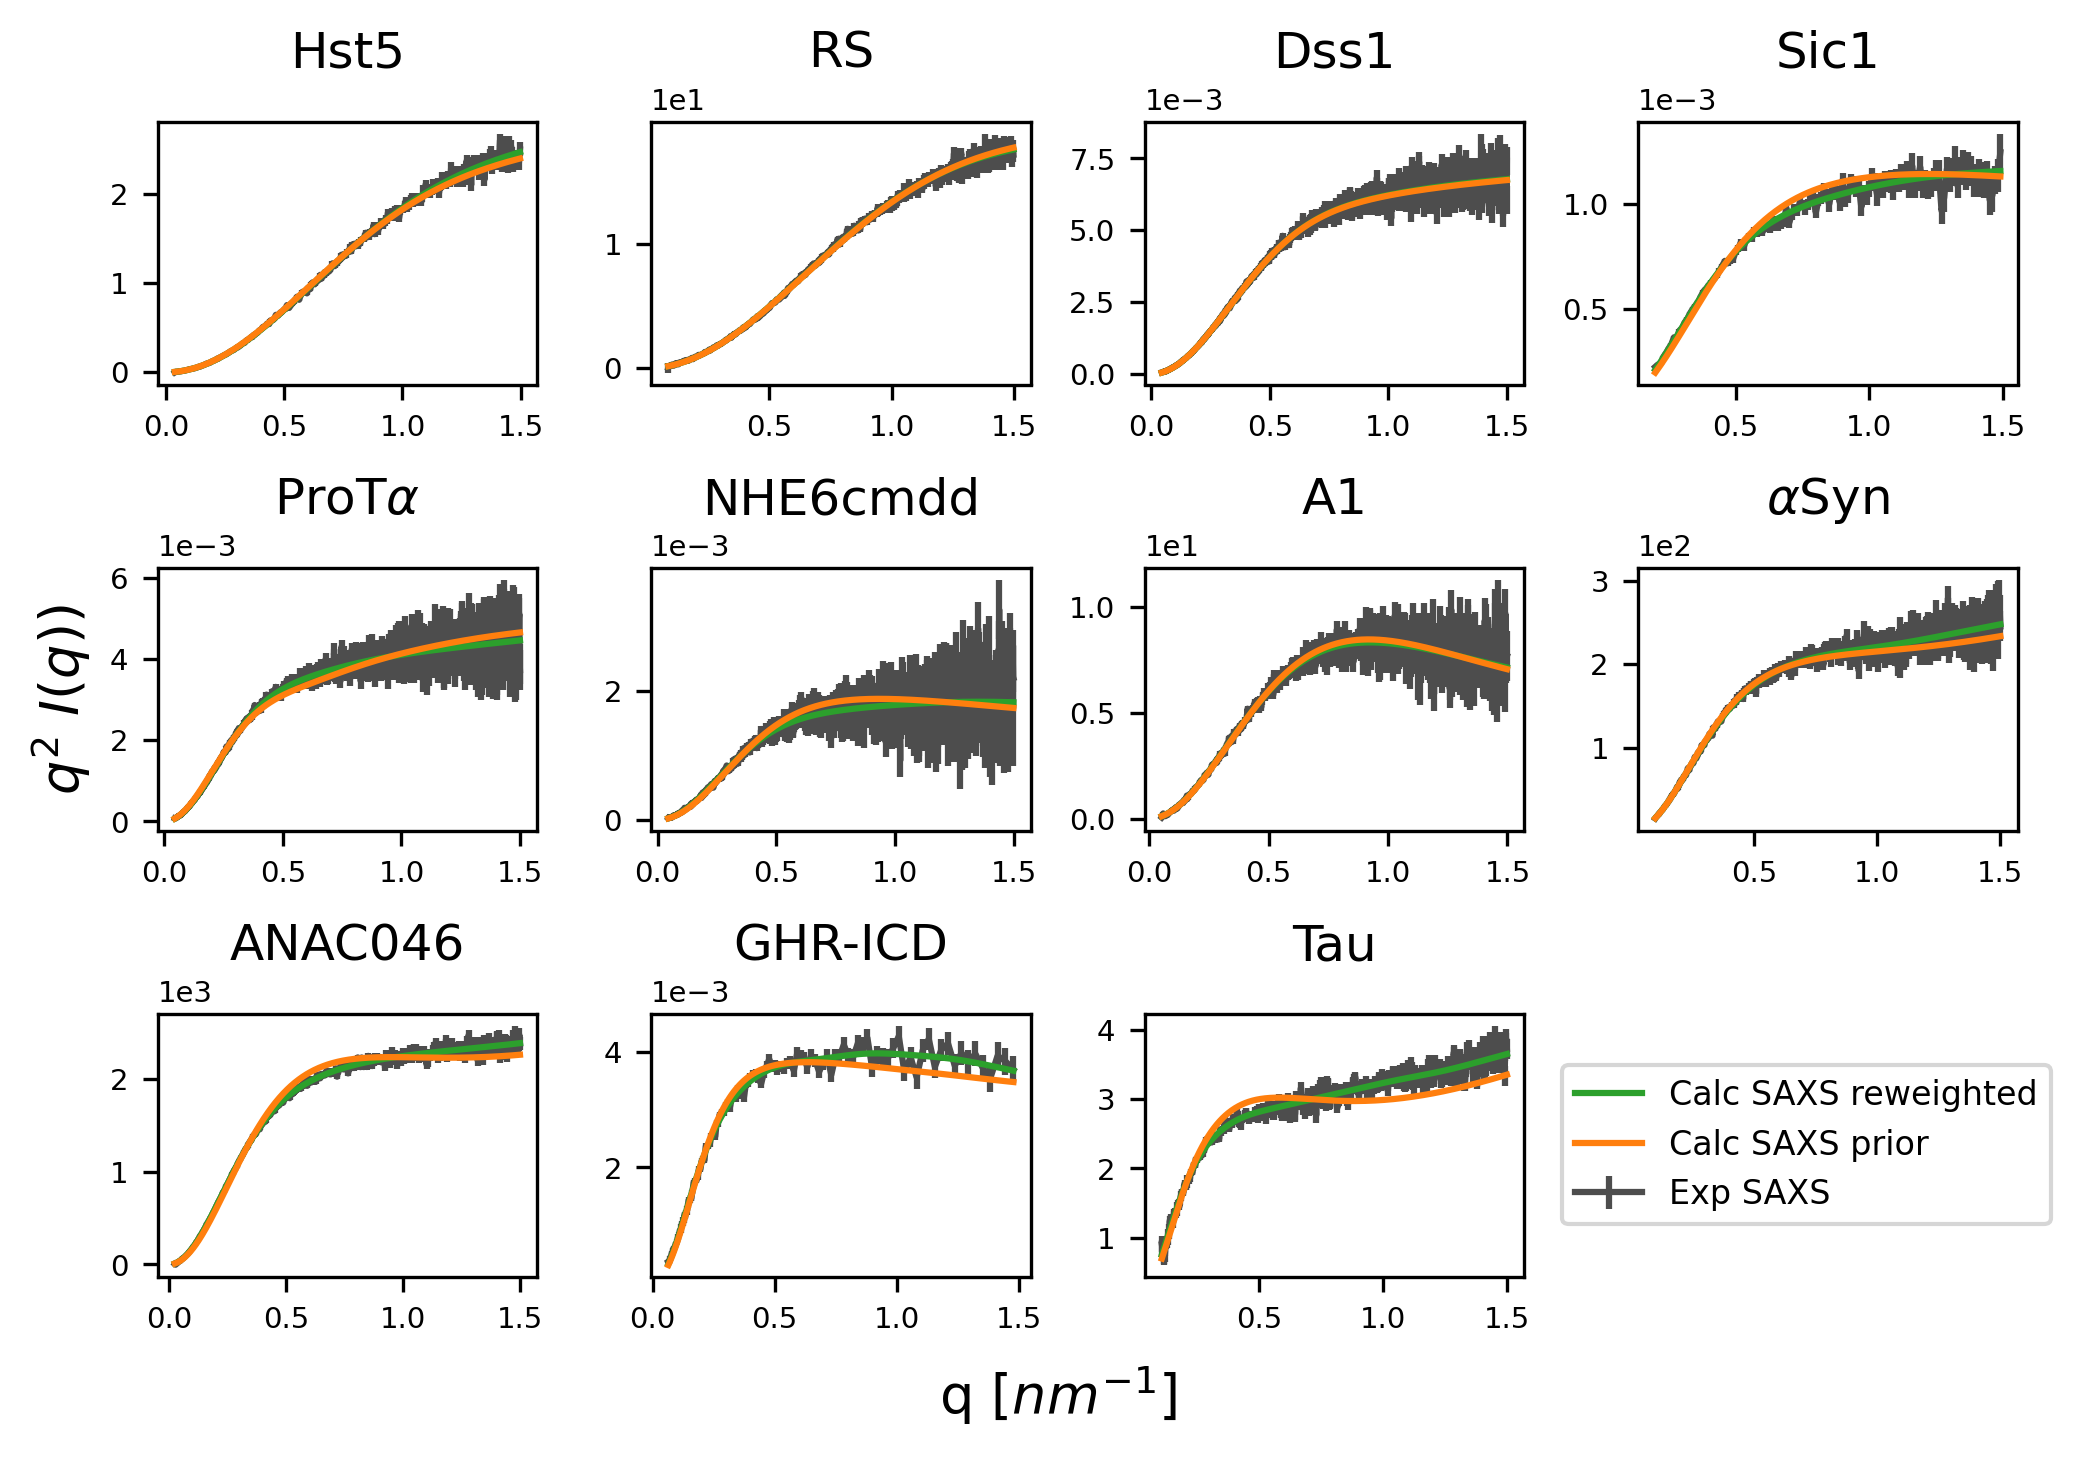

In [196]:
fig, axs = plt.subplots(3, 4, figsize=(8,5), facecolor='w', dpi=300)
for i, (p,ax) in enumerate(zip(dataset.index, axs.flatten())):
    ndx = exp_saxs[p][...,0] < 1.5
    
    q = exp_saxs[p][...,0]
    kratky_exp = (q**2)*exp_saxs[p][...,1]
    kratky_err = (q**2)*exp_saxs[p][...,2]
    calc_i = np.average( calc_saxs_M1[p], weights=weights_M1[p], axis=0 )
    kratky_calc_rew = (q**2)*calc_i
    kratky_calc_ini = (q**2)*calc_saxs_ini_M1[p]
    
    ax.errorbar(q[ndx] ,kratky_exp[ndx] ,kratky_err[ndx], label='Exp SAXS',c='0.3')
    ax.plot(q[ndx], kratky_calc_rew[ndx] ,zorder=100, label='Calc SAXS reweighted',c=c[2])
    ax.plot(q[ndx], kratky_calc_ini[ndx] ,zorder=100, label='Calc SAXS prior',c=c[1])
    
    ax.set_title(names_form[i],pad=13)
    ax.ticklabel_format(style='sci',scilimits=(0,0))
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.yaxis.get_offset_text().set_fontsize(7)
    
axs[-1,-1].axis('off')
axs.flatten()[4].set_ylabel(r'$q^2$ $I(q)$)',fontsize=13)
fig.supxlabel(r'q [$nm^{-1}$]',fontsize=13)
axs.flatten()[-2].legend(fontsize=8, loc=(1.1,0.2))

plt.subplots_adjust(wspace=0.3, 
                    hspace=0.7)

plt.savefig('saxs_m1.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

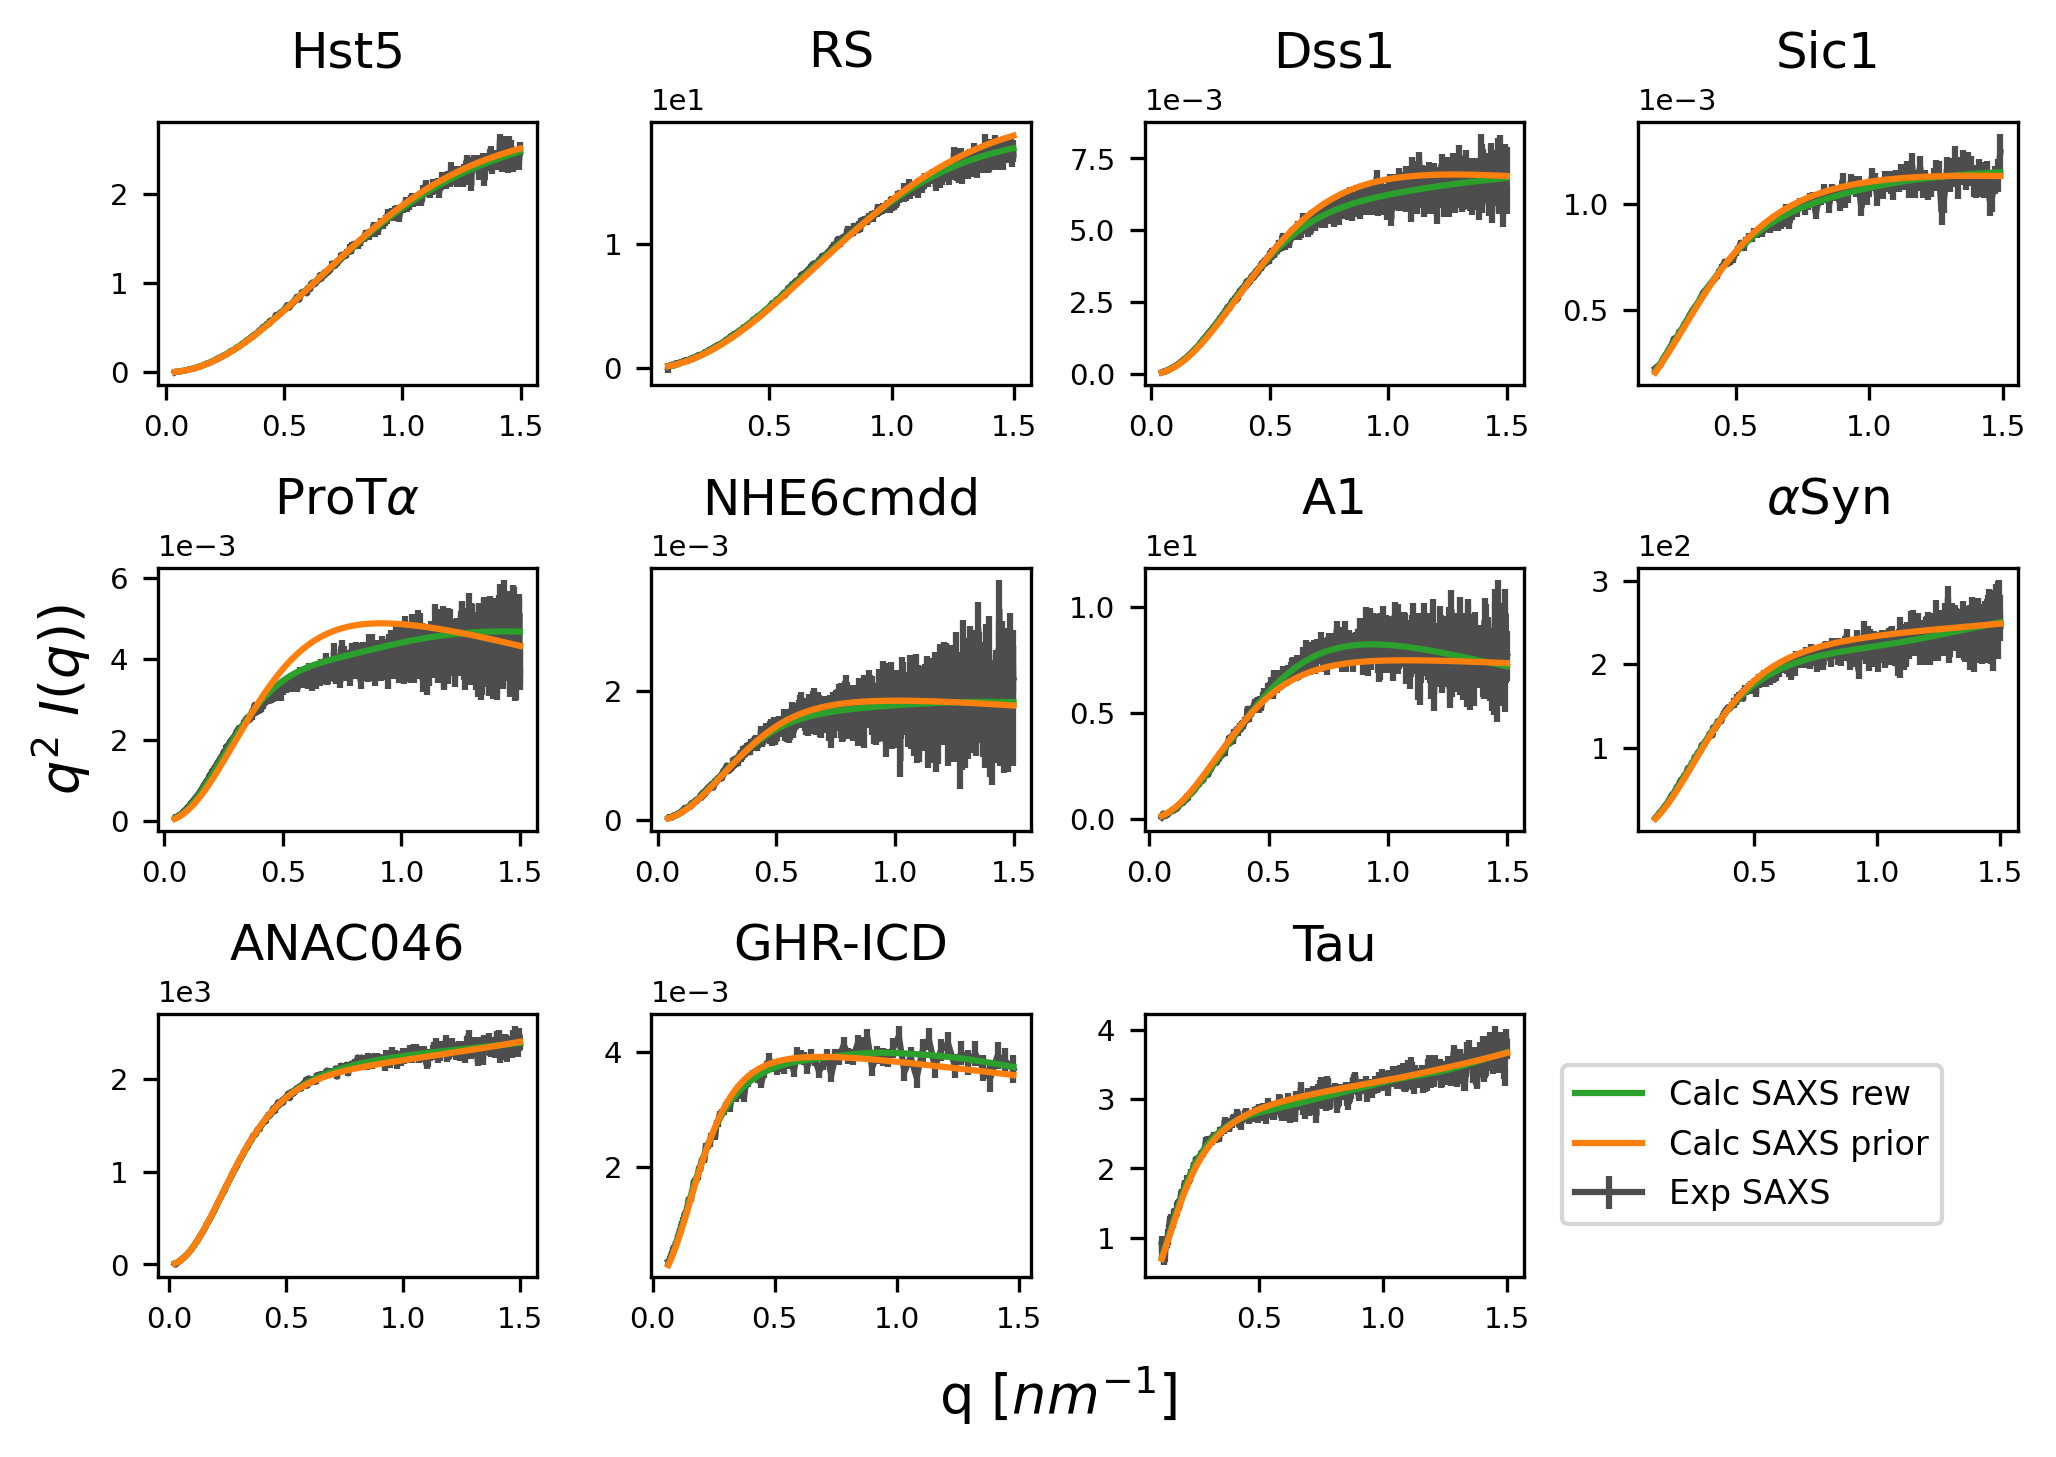

In [194]:
fig, axs = plt.subplots(3, 4, figsize=(8,5), facecolor='w', dpi=300)
for i, (p,ax) in enumerate(zip(dataset.index, axs.flatten())):
    ndx = exp_saxs[p][...,0] < 1.5
    
    q = exp_saxs[p][...,0]
    kratky_exp = (q**2)*exp_saxs[p][...,1]
    kratky_err = (q**2)*exp_saxs[p][...,2]
    calc_i = np.average( calc_saxs_FM[p], weights=weights_FM[p], axis=0 )
    kratky_calc_rew = (q**2)*calc_i
    kratky_calc_ini = (q**2)*calc_saxs_ini_FM[p]
    
    ax.errorbar(q[ndx] ,kratky_exp[ndx] ,kratky_err[ndx], label='Exp SAXS',c='0.3')
    ax.plot(q[ndx], kratky_calc_rew[ndx] ,zorder=100, label='Calc SAXS rew',c=c[2])
    ax.plot(q[ndx], kratky_calc_ini[ndx] ,zorder=100, label='Calc SAXS prior',c=c[1])
    
    ax.set_title(names_form[i],pad=13)
    ax.ticklabel_format(style='sci',scilimits=(0,0))
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.yaxis.get_offset_text().set_fontsize(7)
    
axs[-1,-1].axis('off')
axs.flatten()[4].set_ylabel(r'$q^2$ $I(q)$)',fontsize=13)
fig.supxlabel(r'q [$nm^{-1}$]',fontsize=13)
axs.flatten()[-2].legend(fontsize=8, loc=(1.1,0.2))


plt.subplots_adjust(wspace=0.3, 
                    hspace=0.7)
plt.savefig('saxs_fm.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

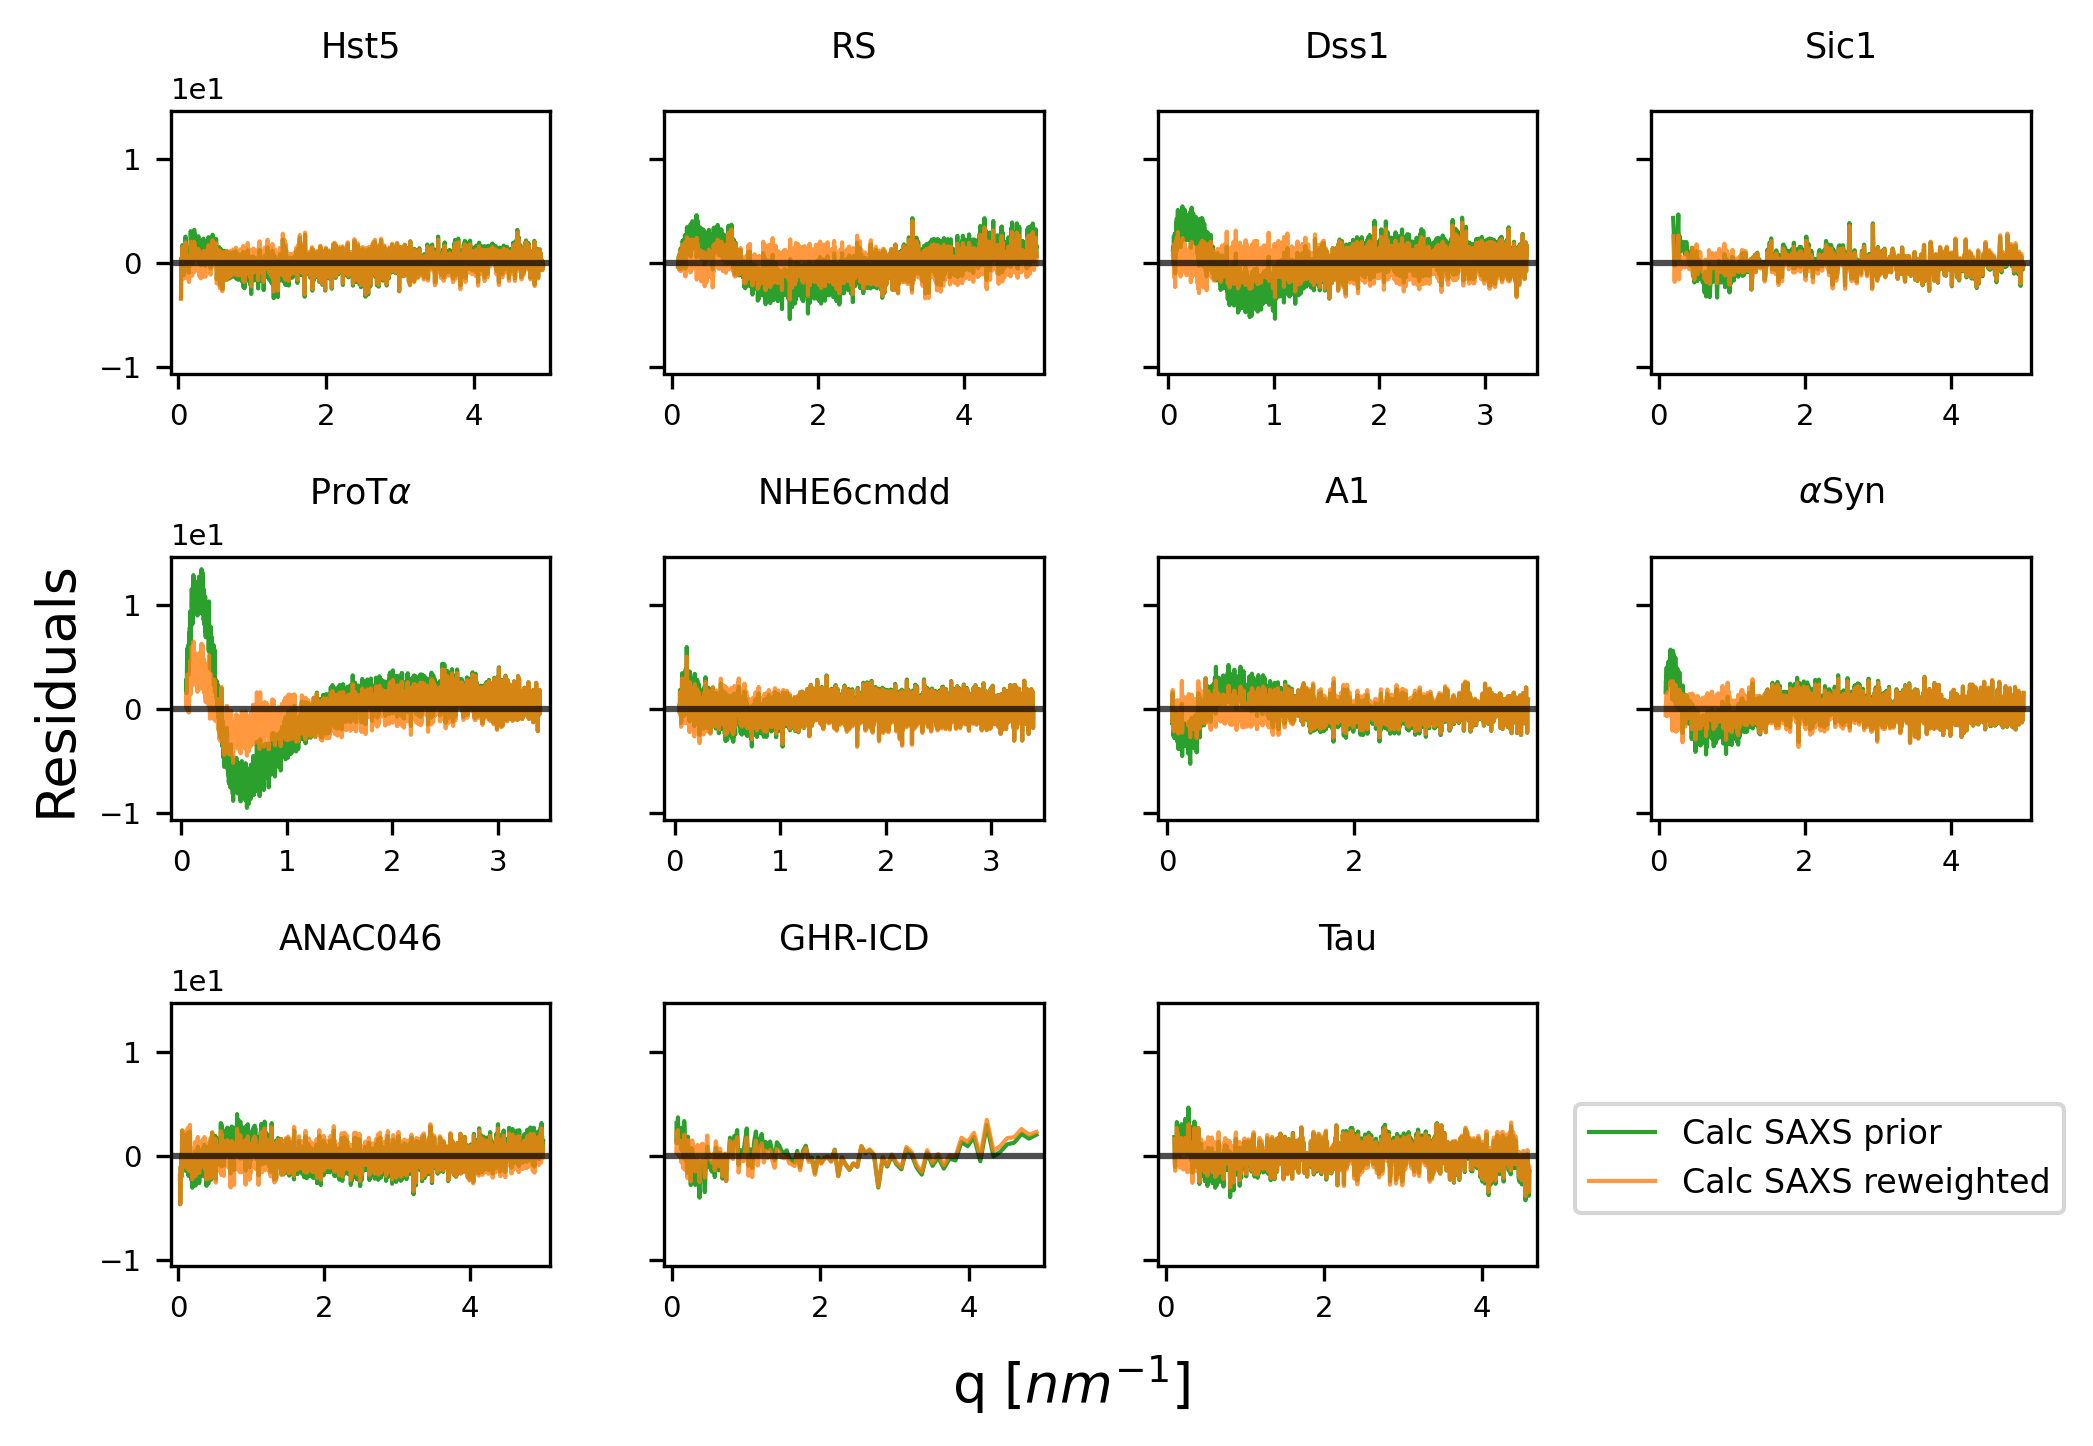

In [602]:
fig, axs = plt.subplots(3, 4, figsize=(8,5), facecolor='w', dpi=300,sharey=True)
for i, (p,ax) in enumerate(zip(dataset.index, axs.flatten())):
    ndx = exp_saxs[p][...,0] < 1.5
    
    q = exp_saxs[p][...,0]
    calc_i = np.average( calc_saxs_FM[p], weights=weights_FM[p], axis=0 )
    residual_rew = (exp_saxs[p][...,1] - calc_i) / exp_saxs[p][...,2]
    
    residual_ini = (exp_saxs[p][...,1] - calc_saxs_ini_FM[p]) / exp_saxs[p][...,2]

    ax.plot(q, residual_ini ,zorder=100, label='Calc SAXS prior',c=c[2], lw=1)
    ax.plot(q, residual_rew ,zorder=100, label='Calc SAXS reweighted',c=c[1], lw=1, alpha=0.8)
    
    ax.set_title(names_form[i],pad=13)
    ax.ticklabel_format(style='sci',scilimits=(0,0))
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.yaxis.get_offset_text().set_fontsize(7)
    #ax.set_xscale('log')
    ax.hlines(0,-0.1,np.max(q)+0.1,color='k',zorder=1000000000000,alpha=0.7)
    ax.set_xlim(-0.1,np.max(q)+0.1)
    
axs[-1,-1].axis('off')
axs.flatten()[4].set_ylabel('Residuals',fontsize=13)
fig.supxlabel(r'q [$nm^{-1}$]',fontsize=13)
axs.flatten()[-2].legend(fontsize=8, loc=(1.1,0.2))

plt.subplots_adjust(wspace=0.3, 
                    hspace=0.7)

plt.savefig('saxs_fm.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

### Rh forward models comparison - M1

In [197]:
Rh_Nyg = {}
Rh_Kirk = {}
Rh_HR = {}
Rh_KirkNyg = {}
for p in dataset.index:
    Rh_Nyg[p] = kde( np.loadtxt(p+'/Rh_Nyg.dat')/10, weights_M1[p] )
    Rh_Kirk[p] = kde( np.loadtxt(p+'/Rh_Kirk_Ca.dat'), weights_M1[p] )
    Rh_HR[p] = kde( np.loadtxt(p+'/Rh_HR.dat'), weights_M1[p])
    Rh_KirkNyg[p] = kde( np.loadtxt(p+'/Rh_Kirk_Ca.dat')*1.186+0.103, weights_M1[p] )

In [1002]:
Rh_Nyg_now = {}
Rh_Kirk_now = {}
Rh_HR_now = {}
Rh_KirkNyg_now = {}
for p in dataset.index:
    Rh_Nyg_now[p] = kde( np.loadtxt(p+'/Rh_Nyg.dat')/10 )
    Rh_Kirk_now[p] = kde( np.loadtxt(p+'/Rh_Kirk_Ca.dat') )
    Rh_HR_now[p] = kde( np.loadtxt(p+'/Rh_HR.dat'))
    Rh_KirkNyg_now[p] = kde( np.loadtxt(p+'/Rh_Kirk_Ca.dat')*1.186+0.103 )

In [1001]:
for p in dataset.index:
    tmp = np.loadtxt('FM_old/'+p+'/Rh_Nyg.dat')/10
    tmp = np.vstack((tmp, np.loadtxt('FM_old/'+p+'/Rh_Kirk_Ca.dat')))
    tmp = np.vstack((tmp, np.loadtxt('FM_old/'+p+'/Rh_HR.dat')))
    tmp = np.vstack((tmp, weights_FM[p]))
    np.savetxt(p+'_rh_w_FM.dat',tmp.T,header='Nygaard Kirkwood HullRad SAXS_weights')

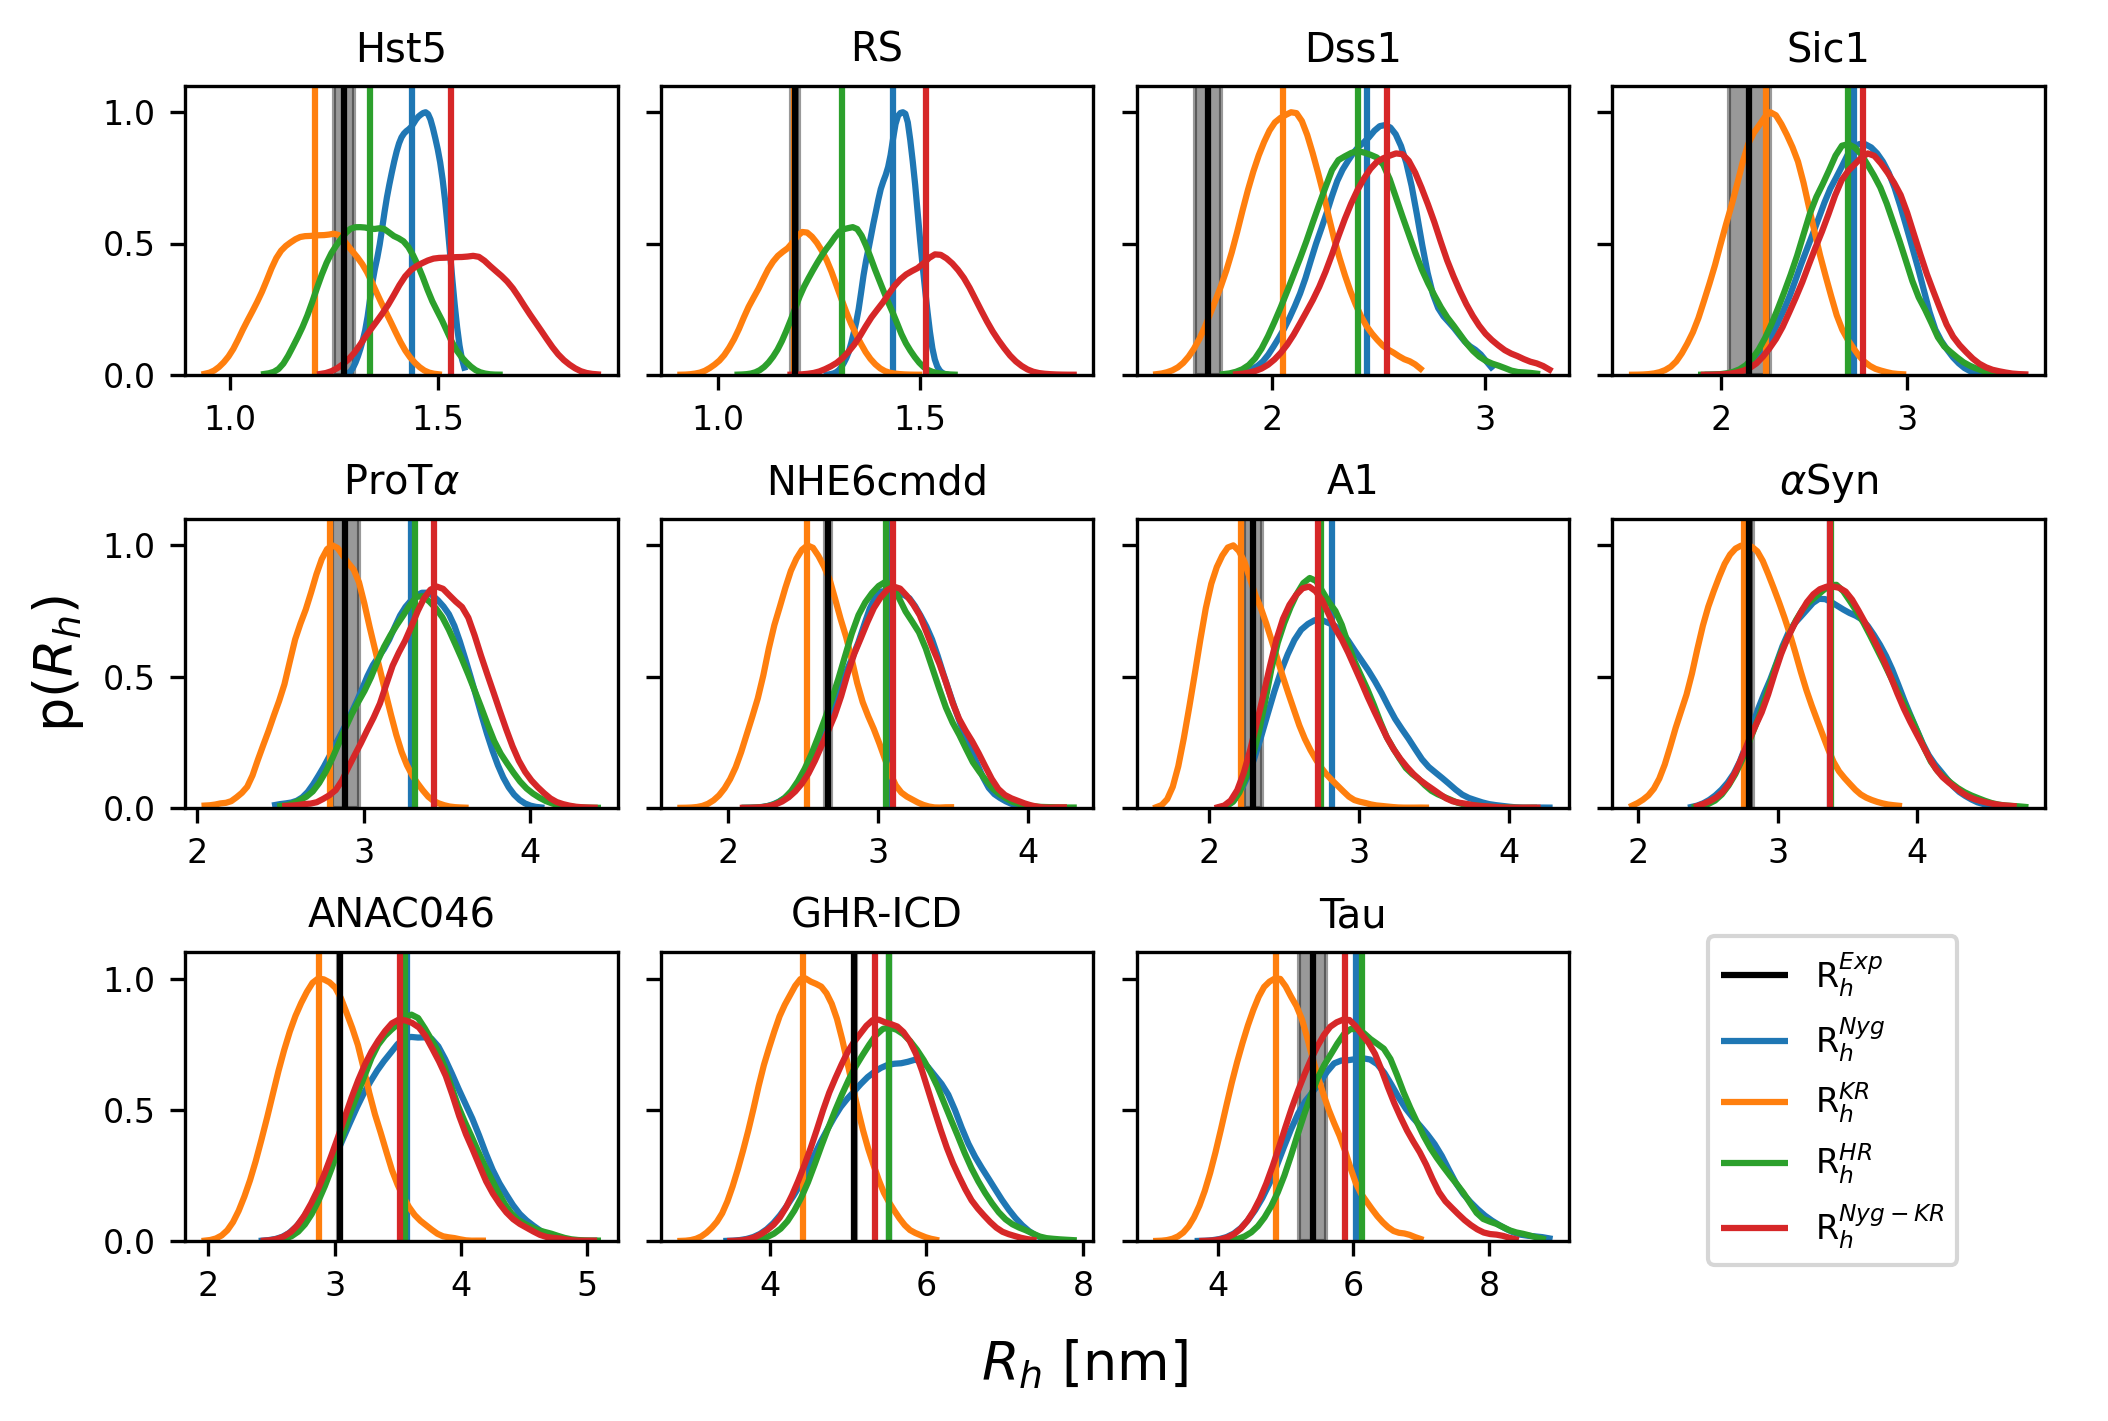

In [259]:
fig, axs = plt.subplots(3, 4, figsize=(8,5), facecolor='w', dpi=300, sharey=True)
for i,(p,ax) in enumerate(zip(dataset.index, axs.flatten())):
    scale = np.max( [Rh_Nyg[p][1].max(), Rh_Kirk[p][1].max(), Rh_HR[p][1].max()] )
    
    ax.plot(Rh_Nyg[p][0], Rh_Nyg[p][1]/scale, label=r'Nygaard ($R_g$)',color=c[0])
    l1 = ax.vlines(Rh_Nyg[p][2],Rh_Nyg[p][1].min()-1,Rh_Nyg[p][1].max()+10,color=c[0])
    
    ax.plot(Rh_Kirk[p][0], Rh_Kirk[p][1]/scale, label='Kirkwood',color=c[1])
    l2 = ax.vlines(Rh_Kirk[p][2],Rh_Kirk[p][1].min()-1,Rh_Kirk[p][1].max()+10,color=c[1])
    
    ax.plot(Rh_HR[p][0], Rh_HR[p][1]/scale, label='HullRad',color=c[2])
    l3 = ax.vlines(Rh_HR[p][2],Rh_HR[p][1].min()-1,Rh_HR[p][1].max()+10,color=c[2])
    
    ax.plot(Rh_KirkNyg[p][0], Rh_KirkNyg[p][1]/scale, label='Nygaard (Kirkwood)',color=c[3])
    l4 = ax.vlines(Rh_KirkNyg[p][2],Rh_KirkNyg[p][1].min()-1,Rh_KirkNyg[p][1].max()+10,color=c[3])
    
    l0 = ax.vlines(dataset.Rh[p],Rh_Nyg[p][1].min()-1,Rh_Nyg[p][1].max()+10,label='Exp',color='k')
    #ax.set_ylim(0,np.max( [Rh_Nyg[p][1].max(), Rh_Kirk[p][1].max(), Rh_HR[p][1].max()] )+0.2)
    ax.set_ylim(0,1.1)
    ax.fill_between((dataset.Rh[p]-dataset.Rh_err[p],dataset.Rh[p]+dataset.Rh_err[p]),0,10,color='k',alpha=0.4)
    ax.set_title(names_form[i])

    
axs[-1,-1].axis('off')
axs.flatten()[4].set_ylabel(r'p($R_h$)', fontsize=13)
fig.supxlabel(r'$R_h$ [nm]', fontsize=13)

plt.subplots_adjust(wspace=0.1, 
                    hspace=0.5)

plt.figlegend( (l0,l1,l2,l3,l4), (r'R$_h^{Exp}$' ,r'R$_h^{Nyg}$', r'R$_h^{KR}$', r'R$_h^{HR}$', r'R$_h^{Nyg-KR}$'), fontsize=8, loc=(0.81,0.11) )
plt.savefig('rh_fwdmod_m1.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

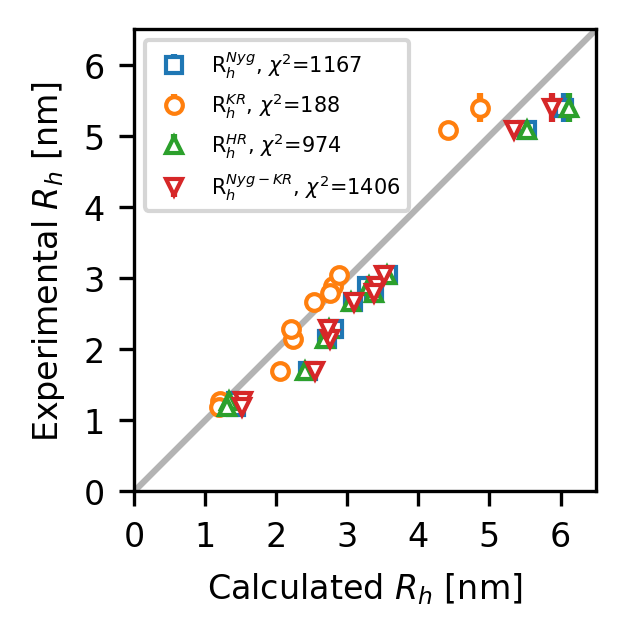

In [287]:
mpl.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(figsize=(2,2), dpi=300)

ax.set_box_aspect(1)
ax.plot([0,100], [0,100], c='0.7')
ax.errorbar([v[2] for x,v in Rh_Nyg.items()], dataset.Rh, dataset.Rh_err, fmt='s', mfc='w', label=r'R$_h^{Nyg}$, $\chi^2$=1167' ,ms=4,alpha=1)
ax.errorbar([v[2] for x,v in Rh_Kirk.items()], dataset.Rh, dataset.Rh_err, fmt='o', mfc='w', label=r'R$_h^{KR}$, $\chi^2$=188' ,ms=4,alpha=1)
ax.errorbar([v[2] for x,v in Rh_HR.items()], dataset.Rh, dataset.Rh_err, fmt='^', mfc='w', label=r'R$_h^{HR}$, $\chi^2$=974' ,ms=4,alpha=1)
ax.errorbar([v[2] for x,v in Rh_KirkNyg.items()], dataset.Rh, dataset.Rh_err, fmt='v', mfc='w', label=r'R$_h^{Nyg-KR}$, $\chi^2$=1406' ,ms=4,alpha=1)
ax.set_xlabel(r'Calculated $R_h$ [nm]')
ax.set_ylabel(r'Experimental $R_h$ [nm]')
ax.set_ylim(0,6.5)
ax.set_xlim(0,6.5)
plt.legend(fontsize=5)
ax.set_xticks(np.arange(7),np.arange(0,7))
ax.set_yticks(np.arange(7),np.arange(0,7))

plt.savefig('rh_fwmod.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

In [540]:
chi2 = ([v[2] for x,v in Rh_Nyg.items()] - dataset.Rh.values)**2 / (dataset.Rh_rel_err.values)**2
print ('Nygaard', chi2.sum())

chi2 = ([v[2] for x,v in Rh_Kirk.items()] - dataset.Rh.values)**2 / (dataset.Rh_rel_err.values)**2
print ('Kirkwood', chi2.sum())

chi2 = ([v[2] for x,v in Rh_HR.items()] - dataset.Rh.values)**2 / (dataset.Rh_rel_err.values)**2
print ('HullRad', chi2.sum())

chi2 = ([v[2] for x,v in Rh_KirkNyg.items()] - dataset.Rh.values)**2 / (dataset.Rh_rel_err.values)**2
print ('Kirkwood-Nygaard', chi2.sum())

Nygaard 1167.1375109669827
Kirkwood 188.52403694800836
HullRad 974.0746771051948
Kirkwood-Nygaard 1405.7599272135017


### Rh forward models comparison - FM

In [262]:
Rh_Nyg_FM = {}
Rh_Kirk_FM = {}
Rh_HR_FM = {}
Rh_KirkNyg_FM = {}
for p in dataset.index:
    Rh_Nyg_FM[p] = kde( np.loadtxt('FM_old/'+p+'/Rh_Nyg.dat')/10, weights_FM[p] )
    Rh_Kirk_FM[p] = kde( np.loadtxt('FM_old/'+p+'/Rh_Kirk_Ca.dat'), weights_FM[p] )
    Rh_HR_FM[p] = kde( np.loadtxt('FM_old/'+p+'/Rh_HR.dat'), weights_FM[p])
    Rh_KirkNyg_FM[p] = kde( np.loadtxt('FM_old/'+p+'/Rh_Kirk_Ca.dat')*1.186+0.103, weights_FM[p] )

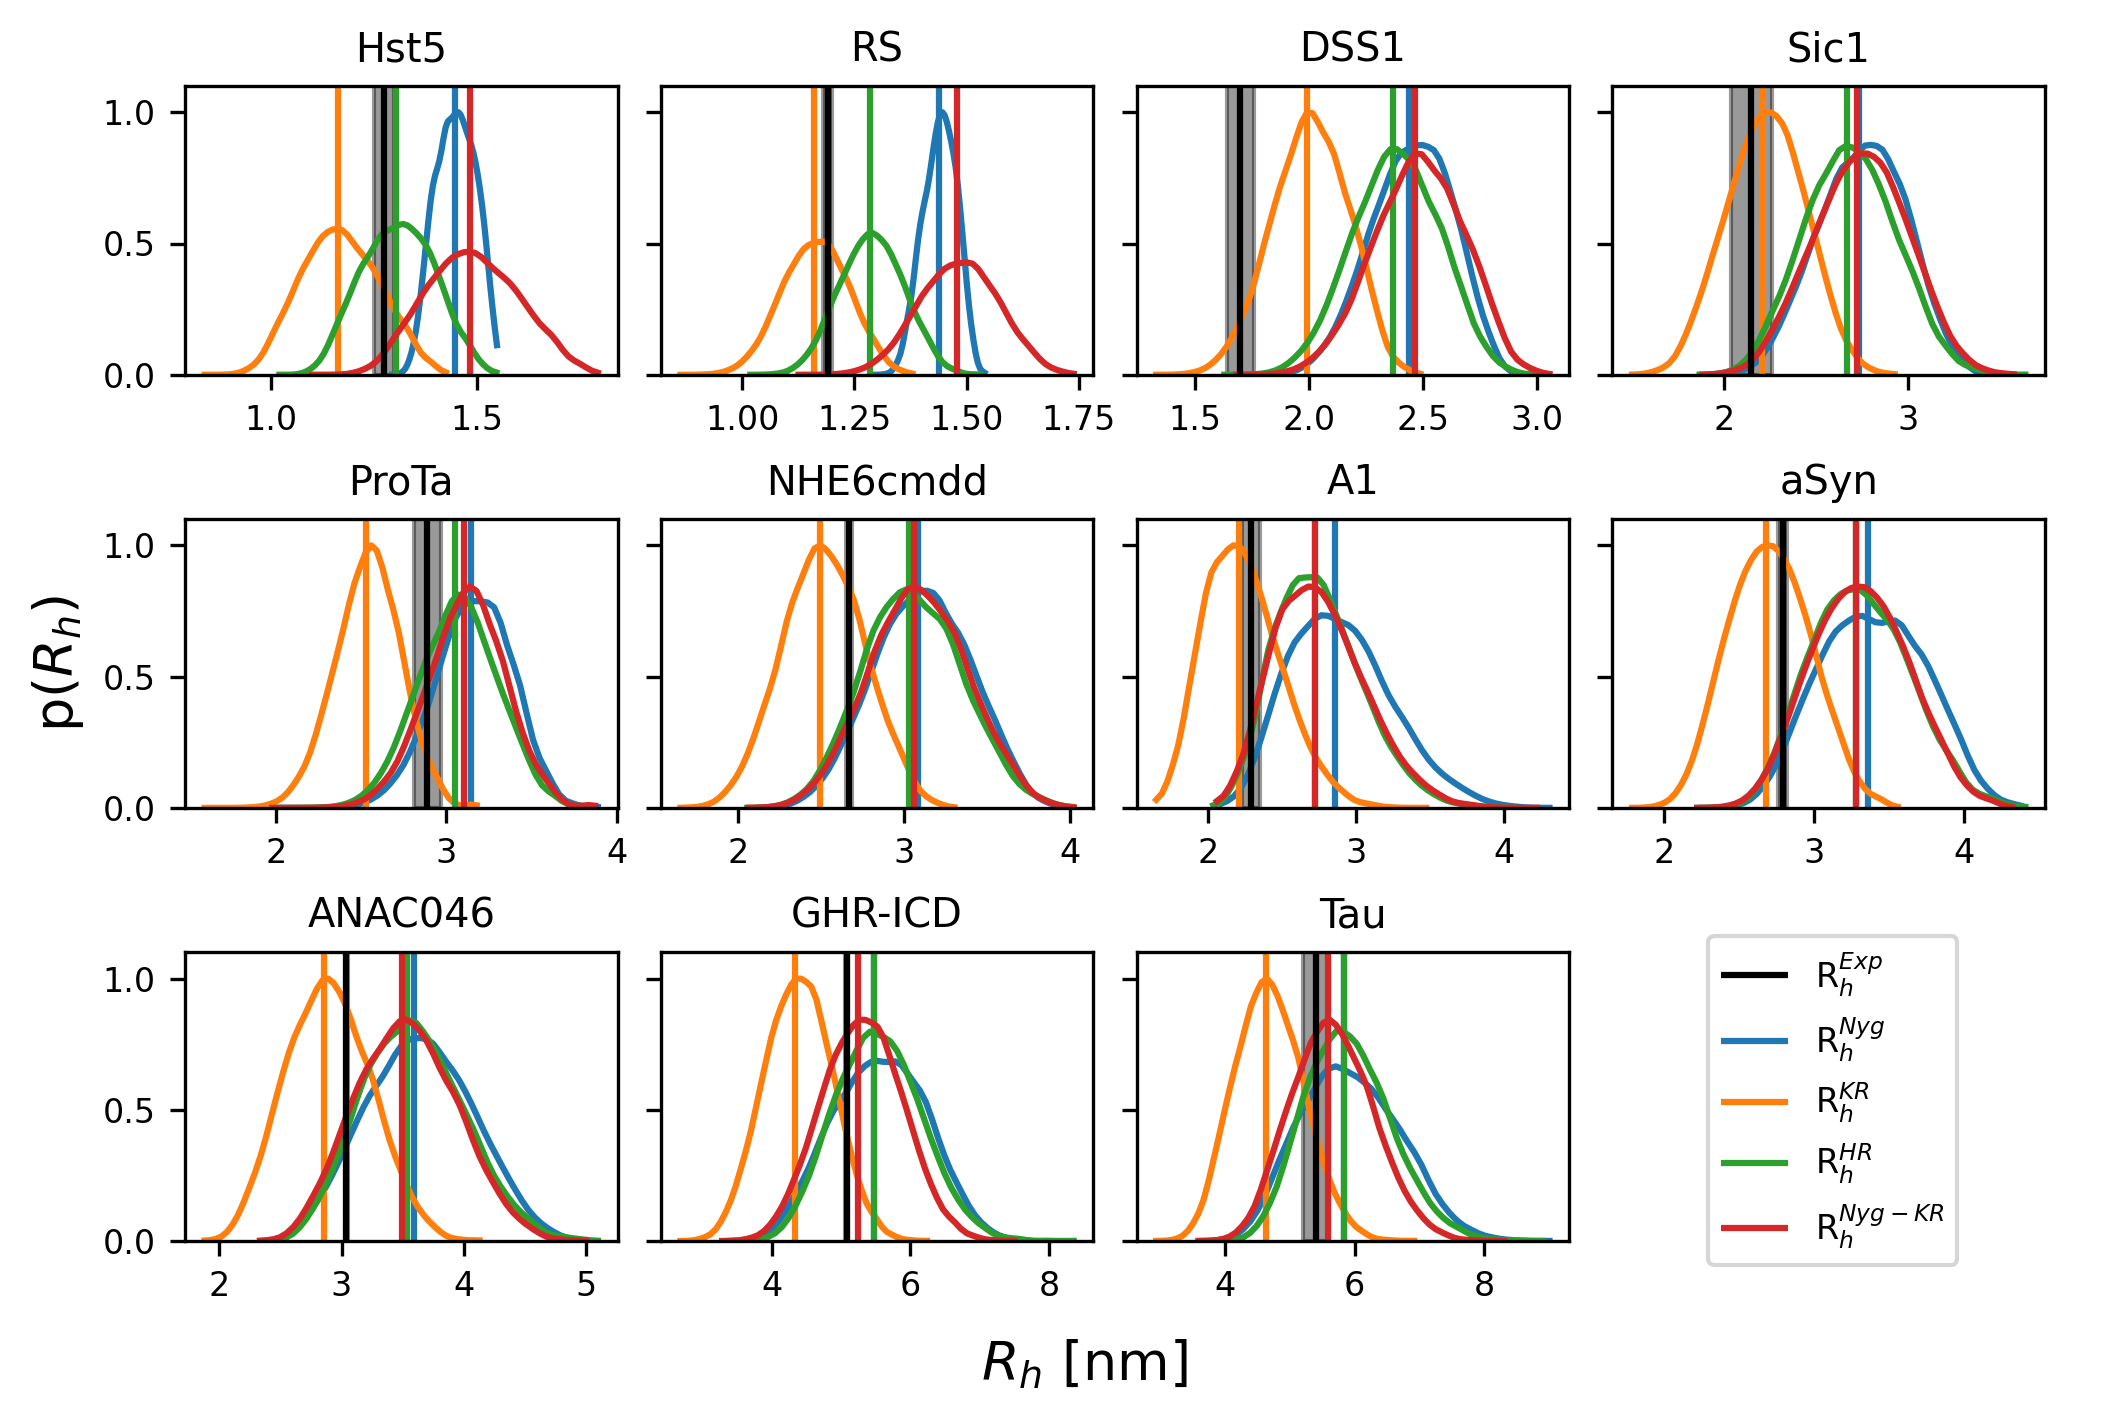

In [264]:
fig, axs = plt.subplots(3, 4, figsize=(8,5), facecolor='w', dpi=300, sharey=True)
for p,ax in zip(dataset.index, axs.flatten()):
    scale = np.max( [Rh_Nyg_FM[p][1].max(), Rh_Kirk_FM[p][1].max(), Rh_HR_FM[p][1].max()] )
    
    ax.plot(Rh_Nyg_FM[p][0], Rh_Nyg_FM[p][1]/scale, label=r'Nygaard ($R_g$)',color=c[0])
    l1 = ax.vlines(Rh_Nyg_FM[p][2],Rh_Nyg_FM[p][1].min()-1,Rh_Nyg_FM[p][1].max()+10,color=c[0])
    
    ax.plot(Rh_Kirk_FM[p][0], Rh_Kirk_FM[p][1]/scale, label='Kirkwood',color=c[1])
    l2 = ax.vlines(Rh_Kirk_FM[p][2],Rh_Kirk_FM[p][1].min()-1,Rh_Kirk_FM[p][1].max()+10,color=c[1])
    
    ax.plot(Rh_HR_FM[p][0], Rh_HR_FM[p][1]/scale, label='HullRad',color=c[2])
    l3 = ax.vlines(Rh_HR_FM[p][2],Rh_HR_FM[p][1].min()-1,Rh_HR_FM[p][1].max()+10,color=c[2])
    
    ax.plot(Rh_KirkNyg_FM[p][0], Rh_KirkNyg_FM[p][1]/scale, label='Nygaard (Kirkwood)',color=c[3])
    l4 = ax.vlines(Rh_KirkNyg_FM[p][2],Rh_KirkNyg_FM[p][1].min()-1,Rh_KirkNyg_FM[p][1].max()+10,color=c[3])
    
    l0 = ax.vlines(dataset.Rh[p],Rh_Nyg_FM[p][1].min()-1,Rh_Nyg_FM[p][1].max()+10,label='Exp',color='k')
    #ax.set_ylim(0,np.max( [Rh_Nyg[p][1].max(), Rh_Kirk[p][1].max(), Rh_HR[p][1].max()] )+0.2)
    ax.set_ylim(0,1.1)
    ax.fill_between((dataset.Rh[p]-dataset.Rh_err[p],dataset.Rh[p]+dataset.Rh_err[p]),0,10,color='k',alpha=0.4)
    ax.set_title(p)

axs[-1,-1].axis('off')
axs.flatten()[4].set_ylabel(r'p($R_h$)', fontsize=13)
fig.supxlabel(r'$R_h$ [nm]', fontsize=13)

plt.subplots_adjust(wspace=0.1, 
                    hspace=0.5)

plt.figlegend( (l0,l1,l2,l3,l4), (r'R$_h^{Exp}$' ,r'R$_h^{Nyg}$', r'R$_h^{KR}$', r'R$_h^{HR}$', r'R$_h^{Nyg-KR}$'), fontsize=8, loc=(0.81,0.11) )
plt.savefig('rh_fwdmod_FM.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

In [265]:
chi2 = ([v[2] for x,v in Rh_Nyg_FM.items()] - dataset.Rh.values)**2 / (dataset.Rh_rel_err.values)**2
print ('Nygaard', chi2.sum())

chi2 = ([v[2] for x,v in Rh_Kirk_FM.items()] - dataset.Rh.values)**2 / (dataset.Rh_rel_err.values)**2
print ('Kirkwood', chi2.sum())

chi2 = ([v[2] for x,v in Rh_HR_FM.items()] - dataset.Rh.values)**2 / (dataset.Rh_rel_err.values)**2
print ('HullRad', chi2.sum())

chi2 = ([v[2] for x,v in Rh_KirkNyg_FM.items()] - dataset.Rh.values)**2 / (dataset.Rh_rel_err.values)**2
print ('Kirkwood-Nygaard', chi2.sum())

Nygaard 1156.3866450664002
Kirkwood 244.92739453250664
HullRad 791.9708168856376
Kirkwood-Nygaard 1090.4401148769246


### Additional dataset with IDPs that only have $R_h$ (no SAXS)

In [24]:
name_exp = ('SBD','Sm1','CFTR','CTL9','A2','FUS','Ddx4','MSP2','RYBP','Abeta','TC1')

dataset_exp = {}
dataset_exp['name'] = name_exp
dataset_exp['Rh'] = np.array([2.56,2.34,3.2,2.17,2.89,3.32,3.16,3.43,3.95,1.44,2.65])
dataset_exp['Rh_err'] = dataset_exp['Rh']*avg_rel_err
dataset_exp['sequence'] = [open('/storage1/francesco/PROJECTS/ENSEMBLES/TSCL-M1/{:s}.fasta'.format(x)).readlines()[1].strip() for x in dataset_exp['name']]
dataset_exp['length'] = [len(x) for x in dataset_exp['sequence']]

dataset_exp = pd.DataFrame(dataset_exp).sort_values('length').set_index('name')

In [25]:
dataset_exp

Rh    Rh_err                                           sequence  \
name                                                                       
Abeta  1.44  0.030119           DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVV   
SBD    2.56  0.053544  GSMMSASSQSPNPNNPAEYCSTIPPLEYCSTIPPLQQAQASGALSS...   
CTL9   2.17  0.045387  AAEELANAKKLKEQLEKLTVTIPAKAGEGGRLFGSITSKQAAESLQ...   
Sm1    2.34  0.048943  MQNSQDYFYAQNRCQQQQAPSTLRTVTMAEFRRVPLPPMAEVPMLS...   
TC1    2.65  0.055427  HHHHHHMKAKRSHQAIIMSTSLRVSPSIHGYHFDTASRKKAVGNIF...   
A2     2.89  0.060446  GHMGRGGNFGFGDSRGGGGNFGPGPGSNFRGGSDGYGSGRGFGDGY...   
FUS    3.32  0.069440  MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTD...   
CFTR   3.20  0.066930  GAMESAERRNSILTETLHRFSLEGDAPVSWTETKKQSFKQTGEFGE...   
RYBP   3.95  0.082617  HHHHHHMTMGDKKSPTRPKRQAKPAADEGFWDCSVCTFRNSAEAFK...   
Ddx4   3.16  0.066094  MGDEDWEAEINPHMSSYVPIFEKDRYSGENGDNFNRTPASSSEMDD...   
MSP2   3.43  0.071741  MIKNESKYSNTFINNAYNMSIRRSMAESKPSTGAGGSAGGSAGGSA...   

       length  
name           
Abeta      40  
SBD        61  
CTL9       92  
Sm1       104  
TC1       112  
A2        155  
FUS       163  
CFTR      189  
RYBP      234  
Ddx4      236  
MSP2      237

In [26]:
names_form_exp = ['Abeta', 'SBD', 'CTL9', 'Sml1', 'TC1', 'A2', 'FUS', 'CFTR', 'RYBP',
       'Ddx4', 'MSP2']

In [ ]:
# Load trajectories
traj = {}
folder = '/storage1/francesco/PROJECTS/ENSEMBLES/TSCL-M1/'
for p in name:
    traj[p] = md.load(folder+p+'/traj.dcd', top=folder+p+'/top.pdb')

In [ ]:
'''
#Subsample trajectories

residues = pd.read_csv('/storage1/francesco/PROJECTS/IDP_EVO/MAIN/residues.csv').set_index('one', drop=False)

for p,t in traj.items():
    #shutil.rmtree(folder+p+'/CG_frames')
    os.mkdir(folder+p+'/CG_frames')
    seq3 = [residues.three[x] for x in dataset.sequence[p]]
    t = fix_topology(t, seq3)
    for c,i in enumerate(t[1000::10]):
        i.save_pdb(folder+p+'/CG_frames/frame{}.pdb'.format(c))
'''

In [549]:
Rh_Nyg_exp = []
Rh_Kirk_exp = []
Rh_HR_exp = []
Rh_KirkNyg_exp = []
for p in dataset_exp.index:
    Rh_Nyg_exp.append( kde( np.loadtxt(p+'/Rh_Nyg.dat')/10 )[2] )
    Rh_Kirk_exp.append( kde( np.loadtxt(p+'/Rh_Kirk_Ca.dat') )[2] )
    Rh_HR_exp.append(  kde( np.loadtxt(p+'/Rh_HR.dat') )[2] )
    Rh_KirkNyg_exp.append( kde( np.loadtxt(p+'/Rh_Kirk_Ca.dat')*1.186+0.103)[2] )

In [550]:
chi2_Nyg = ( (Rh_Nyg_exp - dataset_exp.Rh.values)**2 / (dataset_exp.Rh_err.values)**2 ).sum()
chi2_Kirk = ( (Rh_Kirk_exp - dataset_exp.Rh.values)**2 / (dataset_exp.Rh_err.values)**2 ).sum()
chi2_HR = ( (Rh_HR_exp - dataset_exp.Rh.values)**2 / (dataset_exp.Rh_err.values)**2 ).sum()
chi2_KirkNyg = ( (Rh_KirkNyg_exp - dataset_exp.Rh.values)**2 / (dataset_exp.Rh_err.values)**2 ).sum()

In [304]:
'''
for p in dataset_exp.index:
    rs = calcRs(md.load_dcd(folder+p+'/traj.dcd',top=folder+p+'/top.pdb'))
    np.save('Rs_'+p,rs)

'''

"\nfor p in dataset_exp.index:\n    rs = calcRs(md.load_dcd(folder+p+'/traj.dcd',top=folder+p+'/top.pdb'))\n    np.save('Rs_'+p,rs)\n\n"

In [7]:
nu1 = []
r0 = []
f = lambda x,R0,v : R0*np.power(x,v)
for p in dataset.index:
    ij, dij, dmax = np.load('Rs_{}.npy'.format(p),allow_pickle=True)
    popt, pcov = curve_fit(f,ij[ij>10],dij[ij>10],p0=[.4,.5])
    r0.append(popt[0])
    nu1.append(popt[1])
    
r0_fix = np.average(r0)
nu2 = []
f = lambda x,v : r0_fix*np.power(x,v)
for p in dataset.index:
    ij, dij, dmax = np.load('Rs_{}.npy'.format(p),allow_pickle=True)
    popt, pcov = curve_fit(f,ij[ij>10],dij[ij>10],p0=[.5])
    nu2.append(popt[0])

In [9]:
r0_fix

0.6844214126536614

In [27]:
nu1 = []
r0 = []
f = lambda x,R0,v : R0*np.power(x,v)
for p in dataset_exp.index:
    ij, dij, dmax = np.load('Rs_{}.npy'.format(p),allow_pickle=True)
    popt, pcov = curve_fit(f,ij[ij>10],dij[ij>10],p0=[.4,.5])
    r0.append(popt[0])
    nu1.append(popt[1])
    
r0_fix = np.average(r0)
nu2_exp = []
f = lambda x,v : 0.7*np.power(x,v)
for p in dataset_exp.index:
    ij, dij, dmax = np.load('Rs_{}.npy'.format(p),allow_pickle=True)
    popt, pcov = curve_fit(f,ij[ij>10],dij[ij>10],p0=[.5])
    nu2_exp.append(popt[0])

In [356]:
dev_Nyg = ([v[2] for x,v in Rh_Nyg.items()] - dataset.Rh.values) / (dataset.Rh.values)
dev_Kirk = ([v[2] for x,v in Rh_Kirk.items()] - dataset.Rh.values) / (dataset.Rh.values)
dev_HR = ([v[2] for x,v in Rh_HR.items()] - dataset.Rh.values) / (dataset.Rh.values)
dev_KirkNyg = ([v[2] for x,v in Rh_KirkNyg.items()] - dataset.Rh.values) / (dataset.Rh.values)

In [324]:
dev_Nyg_exp = (Rh_Nyg_exp - dataset_exp.Rh.values) / (dataset_exp.Rh.values)
dev_Kirk_exp = (Rh_Kirk_exp - dataset_exp.Rh.values) / (dataset_exp.Rh.values)
dev_HR_exp = (Rh_HR_exp - dataset_exp.Rh.values) / (dataset_exp.Rh.values)
dev_KirkNyg_exp = (Rh_KirkNyg_exp - dataset_exp.Rh.values) / (dataset_exp.Rh.values)

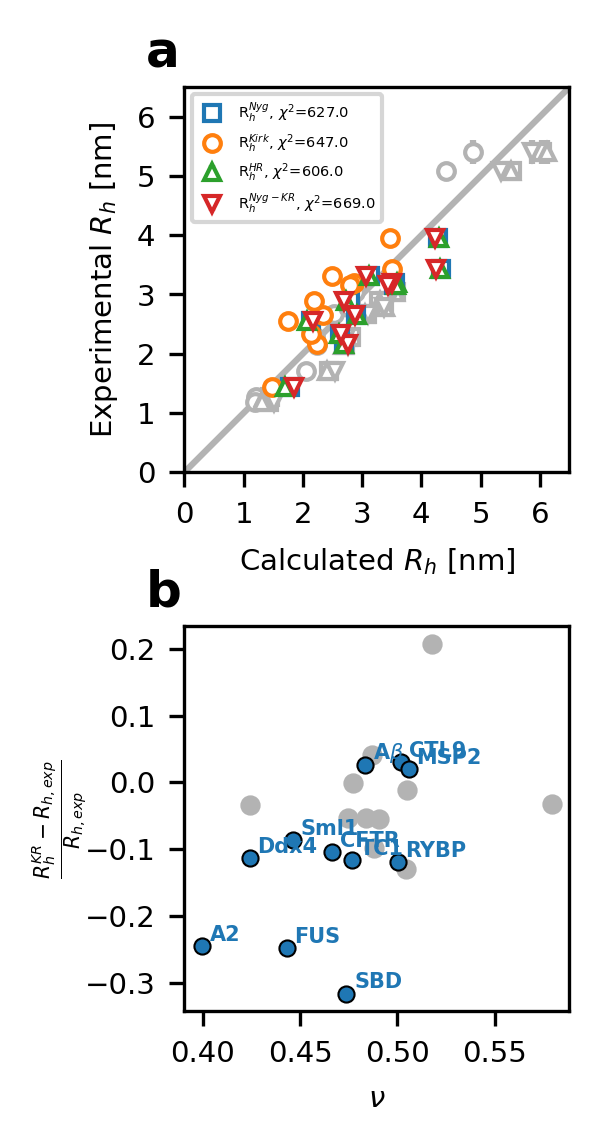

In [551]:
fig, axs = plt.subplots(2, 1, figsize=(2,4), facecolor='w', dpi=300)

axs[0].set_box_aspect(1)
axs[0].plot([0,100], [0,100], c='0.7')
axs[0].errorbar([v[2] for x,v in Rh_Nyg.items()], dataset.Rh, dataset.Rh_err, fmt='s', mfc='w'  ,ms=4,alpha=1,color='0.7')
axs[0].errorbar([v[2] for x,v in Rh_Kirk.items()], dataset.Rh, dataset.Rh_err, fmt='o', mfc='w'  ,ms=4,alpha=1,color='0.7')
axs[0].errorbar([v[2] for x,v in Rh_HR.items()], dataset.Rh, dataset.Rh_err, fmt='^', mfc='w'  ,ms=4,alpha=1,color='0.7')
axs[0].errorbar([v[2] for x,v in Rh_KirkNyg.items()], dataset.Rh, dataset.Rh_err, fmt='v', mfc='w',ms=4,alpha=1,color='0.7')

axs[0].errorbar(Rh_Nyg_exp, dataset_exp.Rh.values, dataset_exp.Rh_err.values, fmt='s', mfc='w', label=r'R$_h^{}$, $\chi^2$={}'.format('{Nyg}',chi2_Nyg.round()) ,ms=4,alpha=1)
axs[0].errorbar(Rh_Kirk_exp, dataset_exp.Rh, dataset_exp.Rh_err, fmt='o', mfc='w', label=r'R$_h^{}$, $\chi^2$={}'.format('{Kirk}',chi2_Kirk.round()) ,ms=4,alpha=1)
axs[0].errorbar(Rh_HR_exp, dataset_exp.Rh, dataset_exp.Rh_err, fmt='^', mfc='w', label=r'R$_h^{}$, $\chi^2$={}'.format('{HR}',chi2_HR.round()) ,ms=4,alpha=1)
axs[0].errorbar(Rh_KirkNyg_exp, dataset_exp.Rh, dataset_exp.Rh_err, fmt='v', mfc='w', label=r'R$_h^{}$, $\chi^2$={}'.format('{Nyg-KR}',chi2_KirkNyg.round()) ,ms=4,alpha=1)

axs[0].set_xlabel(r'Calculated $R_h$ [nm]')
axs[0].set_ylabel(r'Experimental $R_h$ [nm]')
axs[0].set_ylim(0,6.5)
axs[0].set_xlim(0,6.5)
axs[0].legend(fontsize=3.5)
axs[0].set_xticks(np.arange(7),np.arange(0,7))
axs[0].set_yticks(np.arange(7),np.arange(0,7))

axs[1].set_box_aspect(1)
axs[1].scatter(nu2, dev_Kirk,color='0.7',s=15)
axs[1].scatter(nu2_exp, dev_Kirk_exp, edgecolor='k',lw=0.5,s=15)

for i, txt in enumerate(names_form_exp):
    axs[1].annotate(txt, (nu2_exp[i]+0.004, dev_Kirk_exp[i]+0.008), fontsize=5, fontweight='bold', color='tab:blue')
    
#for i, txt in enumerate(dataset.index):
#    ax.annotate(txt, (nu2[i], dev_Kirk[i]), fontsize=4)
    
axs[1].set_ylabel(r'$\frac{R_{h}^{KR}-R_{h,exp}}{R_{h,exp}}$',labelpad=-1)
axs[1].set_xlabel(r'$\nu$')

plt.subplots_adjust(hspace=0.4)

for i, ax in enumerate(axs.flatten()):
    ax.text(-0.1,1.05, string.ascii_lowercase[i], fontsize=12, weight='bold', transform=ax.transAxes)
    
plt.savefig('ext_data.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

In [566]:
pearsonr(nu2_exp, dev_Kirk_exp)

(0.5644738902458935, 0.07044133109416362)

In [498]:
Rh_Nyg_exp = {}
Rh_Kirk_exp = {}
Rh_HR_exp = {}
Rh_KirkNyg_exp = {}
for p in dataset_exp.index:
    Rh_Nyg_exp[p] = kde( np.loadtxt(p+'/Rh_Nyg.dat')/10 )
    Rh_Kirk_exp[p] = kde( np.loadtxt(p+'/Rh_Kirk_Ca.dat') )
    Rh_HR_exp[p] = kde( np.loadtxt(p+'/Rh_HR.dat'))
    Rh_KirkNyg_exp[p] = kde( np.loadtxt(p+'/Rh_Kirk_Ca.dat')*1.186+0.103 )

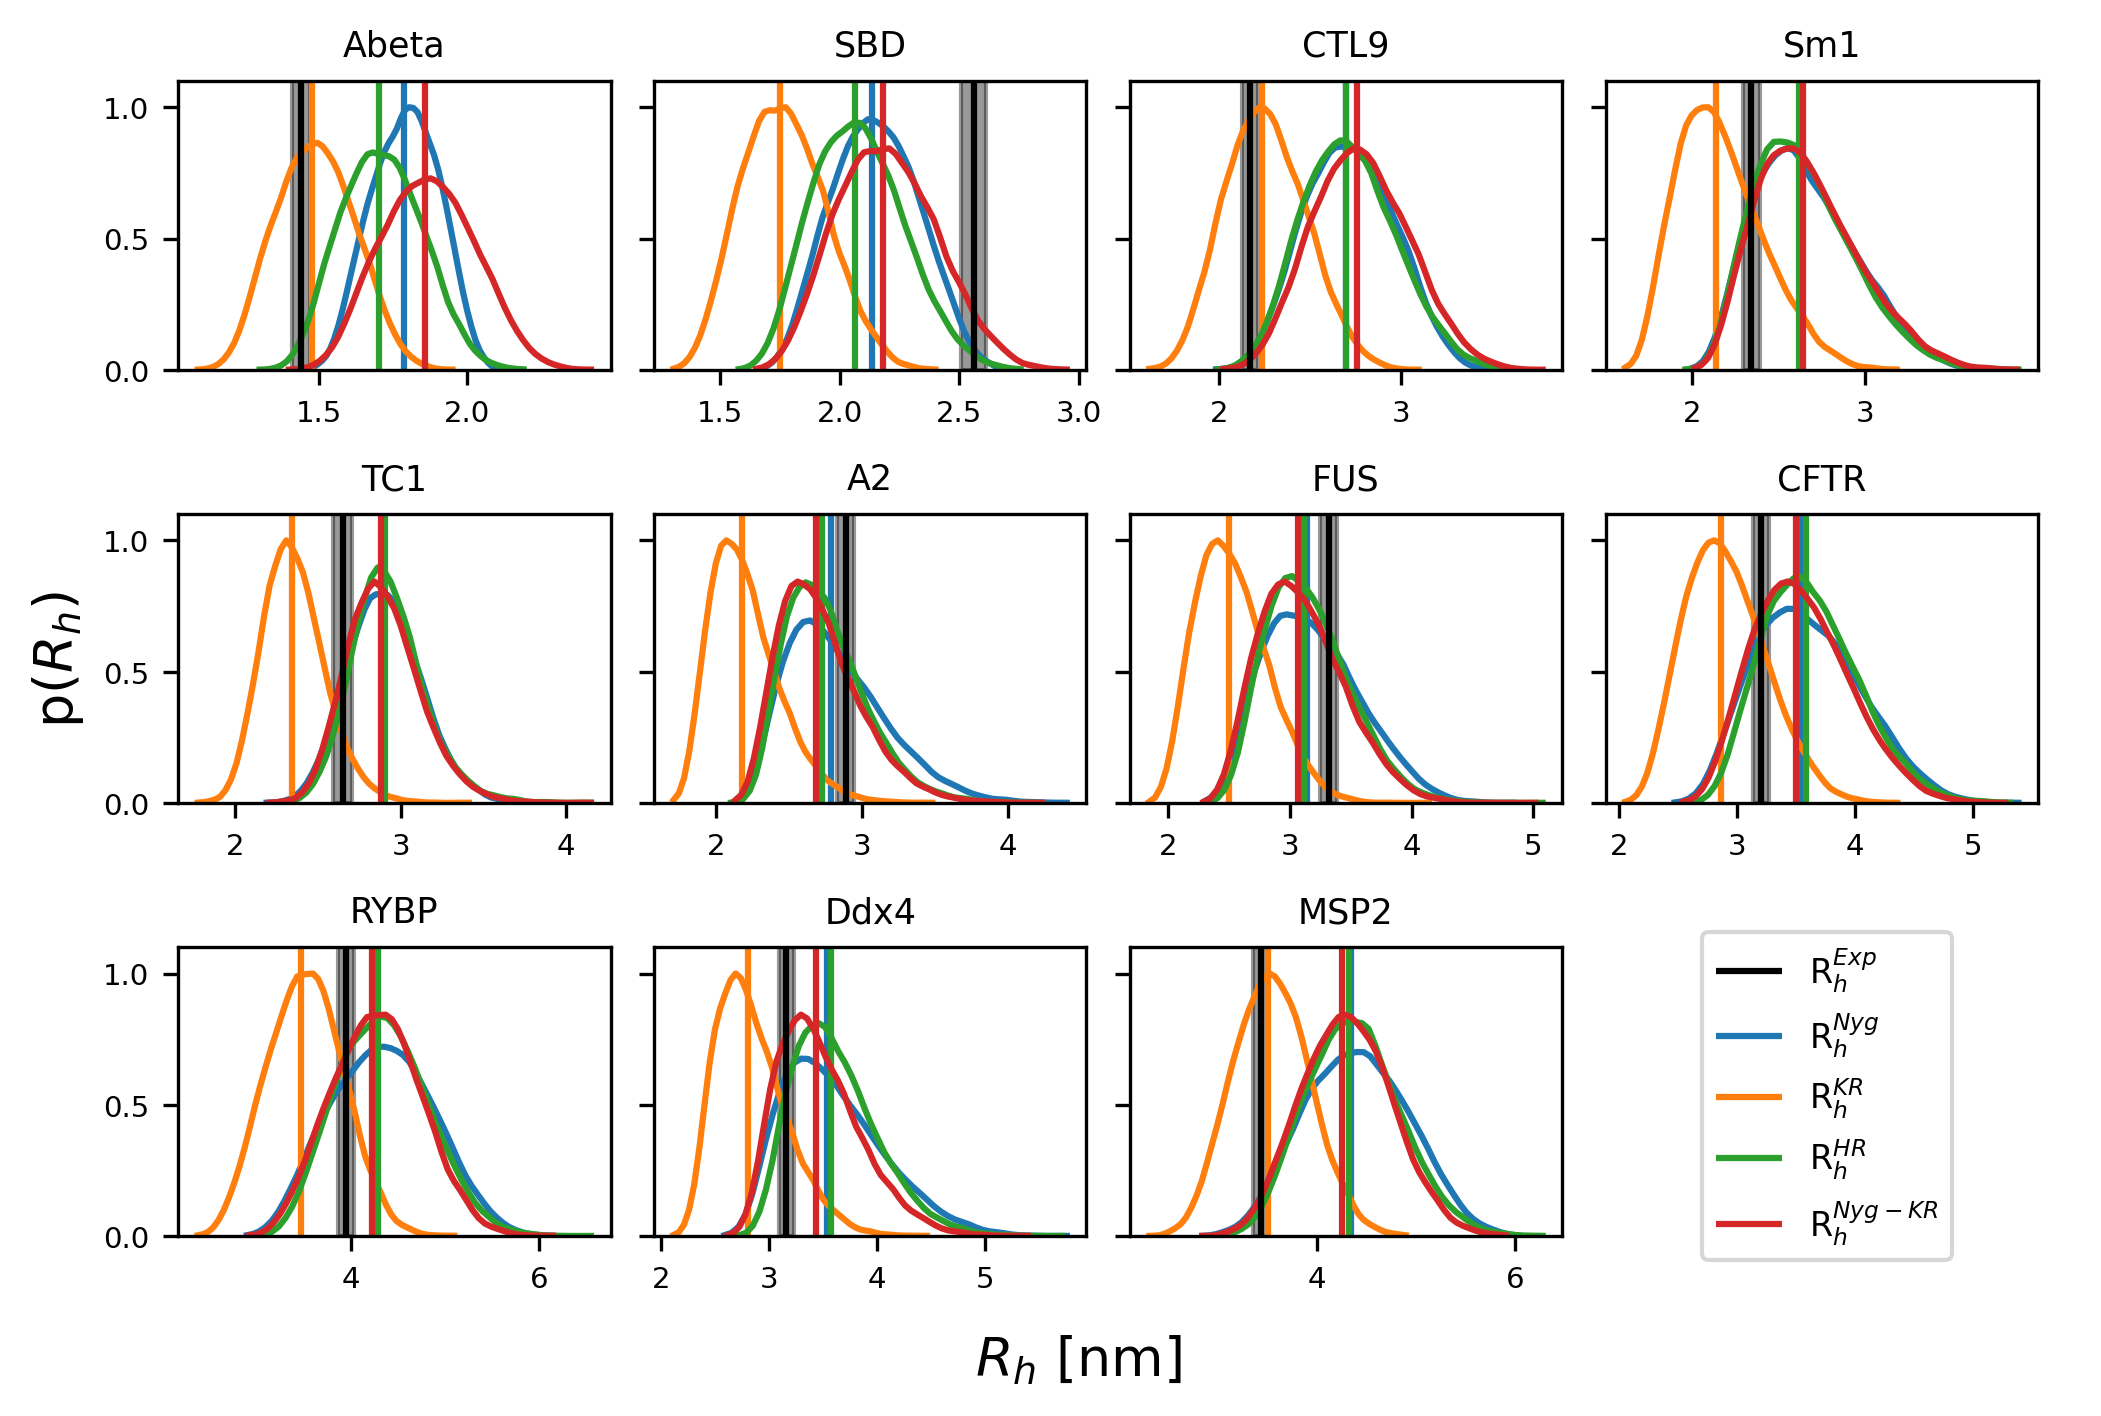

In [499]:
fig, axs = plt.subplots(3, 4, figsize=(8,5), facecolor='w', dpi=300, sharey=True)
for p,ax in zip(dataset_exp.index, axs.flatten()):
    scale = np.max( [Rh_Nyg_exp[p][1].max(), Rh_Kirk_exp[p][1].max(), Rh_HR_exp[p][1].max()] )
    
    ax.plot(Rh_Nyg_exp[p][0], Rh_Nyg_exp[p][1]/scale, label=r'Nygaard ($R_g$)',color=c[0])
    l1 = ax.vlines(Rh_Nyg_exp[p][2],Rh_Nyg_exp[p][1].min()-1,Rh_Nyg_exp[p][1].max()+10,color=c[0])
    
    ax.plot(Rh_Kirk_exp[p][0], Rh_Kirk_exp[p][1]/scale, label='Kirkwood',color=c[1])
    l2 = ax.vlines(Rh_Kirk_exp[p][2],Rh_Kirk_exp[p][1].min()-1,Rh_Kirk_exp[p][1].max()+10,color=c[1])
    
    ax.plot(Rh_HR_exp[p][0], Rh_HR_exp[p][1]/scale, label='HullRad',color=c[2])
    l3 = ax.vlines(Rh_HR_exp[p][2],Rh_HR_exp[p][1].min()-1,Rh_HR_exp[p][1].max()+10,color=c[2])
    
    ax.plot(Rh_KirkNyg_exp[p][0], Rh_KirkNyg_exp[p][1]/scale, label='Nygaard (Kirkwood)',color=c[3])
    l4 = ax.vlines(Rh_KirkNyg_exp[p][2],Rh_KirkNyg_exp[p][1].min()-1,Rh_KirkNyg_exp[p][1].max()+10,color=c[3])
    
    l0 = ax.vlines(dataset_exp.Rh[p],Rh_Nyg_exp[p][1].min()-1,Rh_Nyg_exp[p][1].max()+10,label='Exp',color='k')
    #ax.set_ylim(0,np.max( [Rh_Nyg[p][1].max(), Rh_Kirk[p][1].max(), Rh_HR[p][1].max()] )+0.2)
    ax.set_ylim(0,1.1)
    ax.fill_between((dataset_exp.Rh[p]-dataset_exp.Rh_err[p],dataset_exp.Rh[p]+dataset_exp.Rh_err[p]),0,10,color='k',alpha=0.4)
    ax.set_title(p)

axs[-1,-1].axis('off')
axs.flatten()[4].set_ylabel(r'p($R_h$)', fontsize=13)
fig.supxlabel(r'$R_h$ [nm]', fontsize=13)

plt.subplots_adjust(wspace=0.1, 
                    hspace=0.5)

plt.figlegend( (l0,l1,l2,l3,l4), (r'R$_h^{Exp}$' ,r'R$_h^{Nyg}$', r'R$_h^{KR}$', r'R$_h^{HR}$', r'R$_h^{Nyg-KR}$'), fontsize=8, loc=(0.81,0.11) )
plt.savefig('rh_fwdmod_exp.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

## Plot SAXS data

In [501]:
samples = ('DSS1', 'ProTa', 'NHE6cmdd', 'ANAC046')
# q-range for Guinier analysis from ATSAS autorg
qr = {
    'DSS1': exp_saxs['DSS1'][38:365],
    'ProTa': exp_saxs['ProTa'][24:237],
    'NHE6cmdd': exp_saxs['NHE6cmdd'][36:276],
    'ANAC046': exp_saxs['ANAC046'][16:100]
}

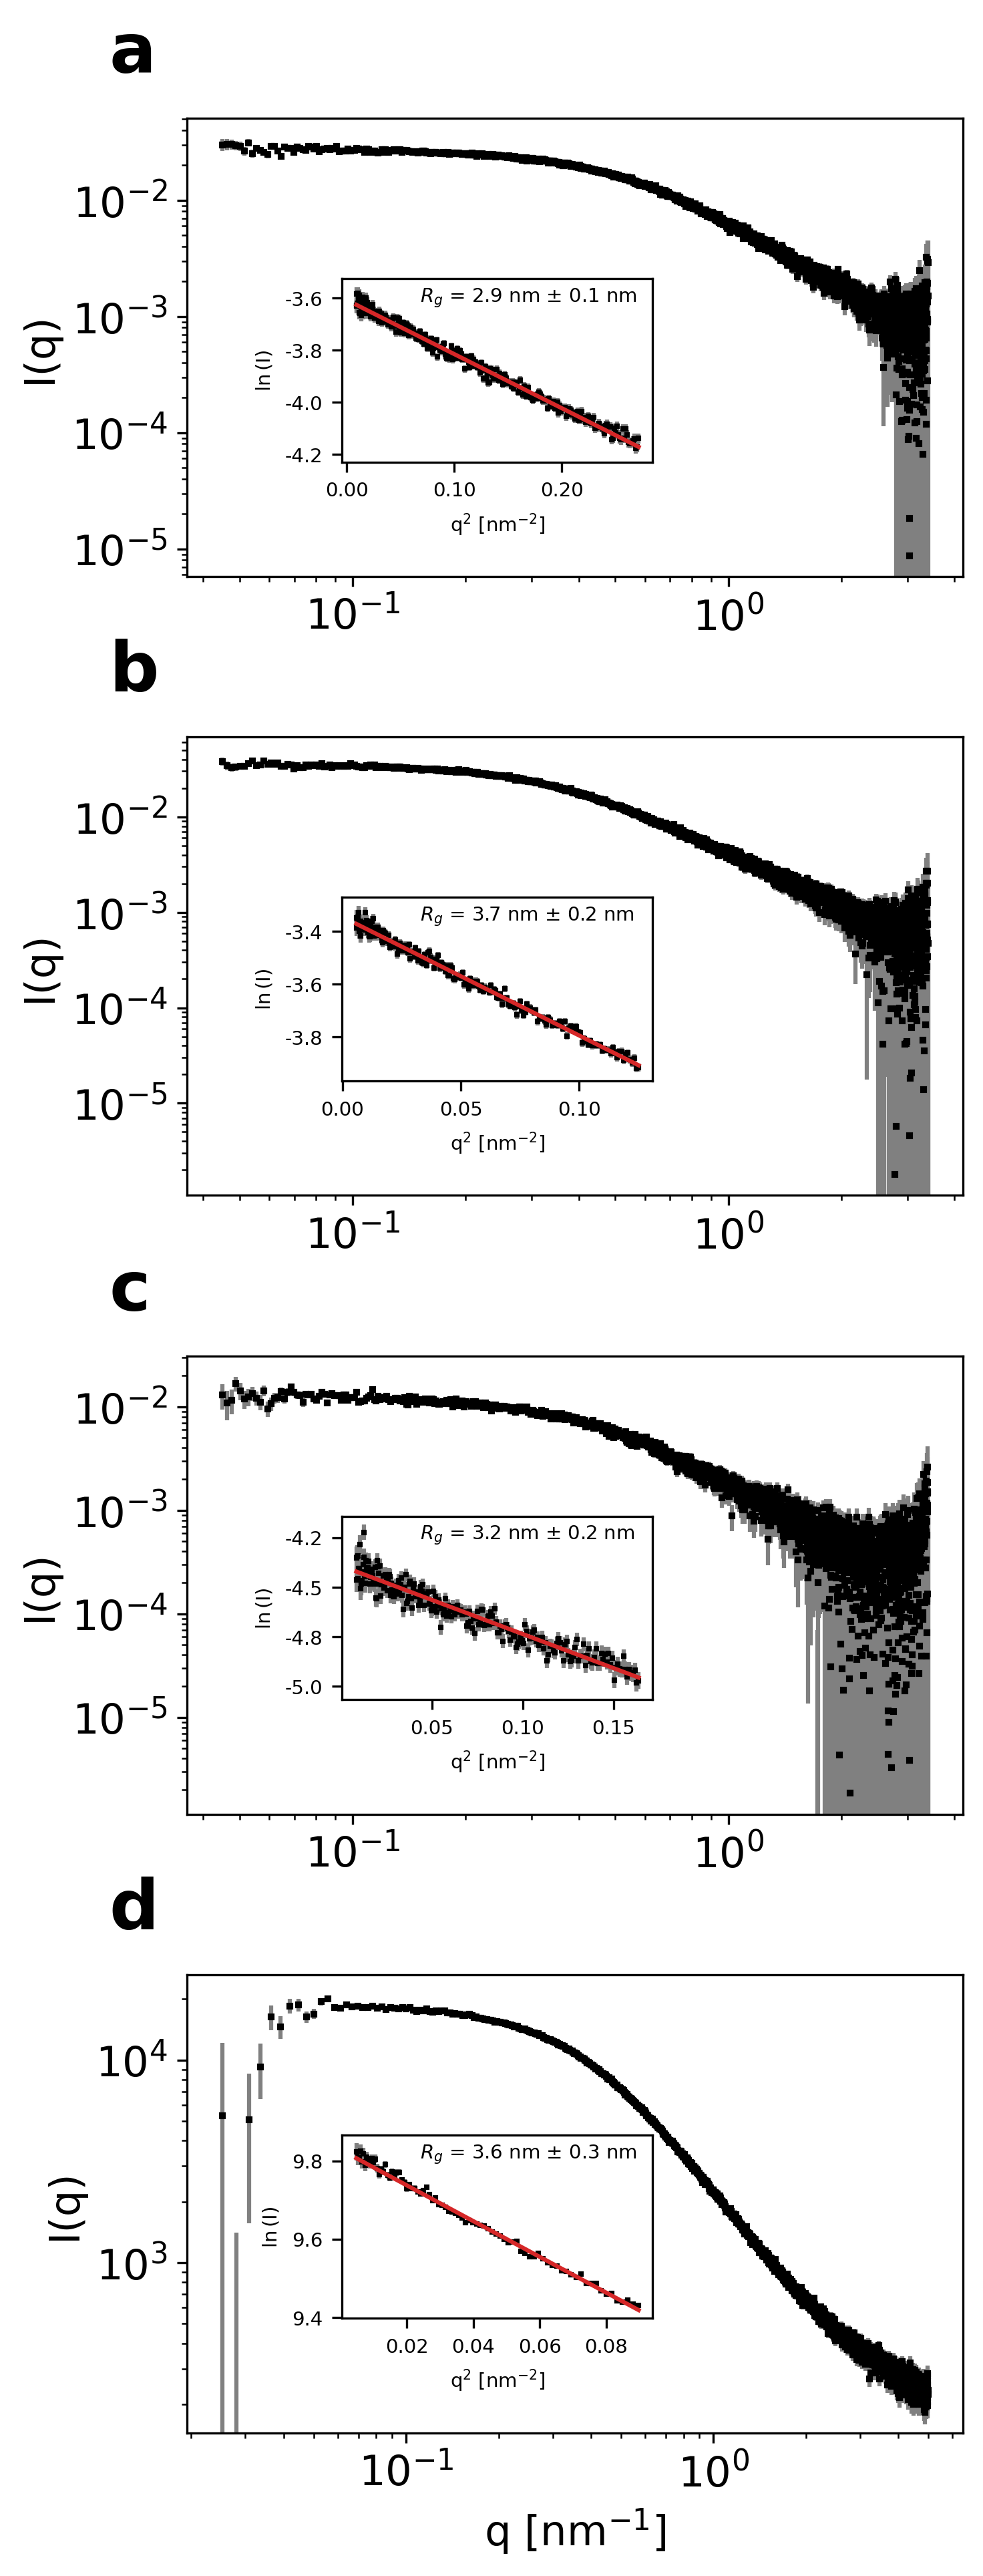

In [587]:
rgs_=[r'$R_g$ = 2.9 nm $\pm$ 0.1 nm', r'$R_g$ = 3.7 nm $\pm$ 0.2 nm', r'$R_g$ = 3.2 nm $\pm$ 0.2 nm', r'$R_g$ = 3.6 nm $\pm$ 0.3 nm']
fig, axs = plt.subplots(4, figsize=(5,15), gridspec_kw={'hspace':0.35, 'wspace':0.25}, dpi=300, facecolor='w')
for ax,p in zip(axs.flatten(), samples):
    q = exp_saxs[p][...,0]
    i = exp_saxs[p][...,1]
    e = exp_saxs[p][...,2]
    ax.errorbar(q, i, e, label='Exp SAXS',c='k', fmt='s', ms=1.5, ecolor='0.5')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel(r'I(q)', fontsize=15)
    
    ins = ax.inset_axes([0.2,0.25,0.4,0.4])
    ins.ticklabel_format(axis='y',style='sci', scilimits=(-100,100))
    ins.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ins.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ins.errorbar(qr[p][...,0]**2, np.log(qr[p][...,1]), qr[p][...,2]/qr[p][...,1], c='k', fmt='s', ms=1, ecolor='0.5')
    a,b = np.polyfit(qr[p][...,0]**2, np.log(qr[p][...,1]), deg=1, w=1/((qr[p][...,2]/qr[p][...,1])**2))
    y = a*qr[p][...,0]**2+b
    ins.plot(qr[p][...,0]**2,y,c='tab:red',zorder=100)
    ins.set_xlabel(r'q$^2$ [nm$^{-2}$]')
    ins.set_ylabel(r'$\ln$(I)')
    

    axs[-1].set_xlabel(r'q [nm$^{-1}$]', fontsize=15)
    
for i, ax in enumerate(axs.flatten()):
    ax.text(-0.1,1.1, string.ascii_lowercase[i], fontsize=25, weight='bold', transform=ax.transAxes)
    ax.tick_params(axis='both', labelsize=15)
    ax.text(0.3,0.6, rgs_[i],transform=ax.transAxes,zorder=10000)
    
#fig.set_size_inches(8, 6)

plt.savefig('saxs_exp.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

## Fig1 manuscript

In [719]:
from random import sample

In [722]:
bf_sample = [0, 0.5, 1]

In [723]:
for i in np.arange(0,20000,200):
    conf = md.load('/storage1/francesco/PROJECTS/ENSEMBLES/aSyn/FM/frame'+str(i)+'.pdb')
    #bf = np.full(len(list(conf.topology.atoms)), weights_FM['aSyn'][i])
    bf = np.full( len(list(conf.topology.atoms)), sample(bf_sample, 1)[0] )
    conf.save_pdb('/storage1/francesco/PROJECTS/RH/fig1ens/frame'+str(i)+'.pdb',bfactors=bf)

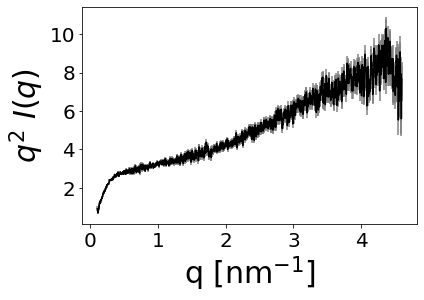

In [570]:
# Tau Kratky plot
p = 'Tau'
ndx = exp_saxs[p][...,0] < 1 

q = exp_saxs[p][...,0]
kratky_exp = (q**2)*exp_saxs[p][...,1]
kratky_err = (q**2)*exp_saxs[p][...,2]

plt.errorbar(q ,kratky_exp ,kratky_err, label='Exp SAXS', color='k', ecolor='0.5')
plt.xlabel(r'q [nm$^{-1}$]', fontsize=30)
plt.ylabel(r'$q^2$ $I(q)$', fontsize=30)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.savefig('fig1_saxs.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

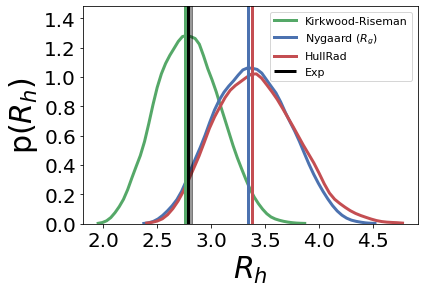

In [491]:
#Tau Kirkwood Rh
p = 'aSyn'

plt.plot(Rh_Kirk[p][0], Rh_Kirk[p][1], label='Kirkwood-Riseman',color=c[1], linewidth=3,zorder=-100)
plt.vlines(Rh_Kirk[p][2],Rh_Kirk[p][1].min()-1,Rh_Kirk[p][1].max()+10,color=c[1], linewidth=3)

plt.plot(Rh_Nyg[p][0], Rh_Nyg[p][1], label=r'Nygaard ($R_g$)',color=c[0], linewidth=3,zorder=-100)
plt.vlines(Rh_Nyg[p][2],Rh_Nyg[p][1].min()-1,Rh_Nyg[p][1].max()+10,color=c[0], linewidth=3)
    
plt.plot(Rh_HR[p][0], Rh_HR[p][1], label='HullRad',color=c[2], linewidth=3,zorder=-100)
plt.vlines(Rh_HR[p][2],Rh_HR[p][1].min()-1,Rh_HR[p][1].max()+10,color=c[2], linewidth=3)

plt.vlines(dataset.Rh[p],Rh_Nyg[p][1].min()-1,Rh_Nyg[p][1].max()+10,label='Exp',color='k', linewidth=3)
plt.ylim(0,np.max( [Rh_Nyg[p][1].max(), Rh_Kirk[p][1].max(), Rh_HR[p][1].max()] )+0.2)
plt.fill_between((dataset.Rh[p]-dataset.Rh_err[p],dataset.Rh[p]+dataset.Rh_err[p]),0,10,color='k',alpha=0.4)
plt.ylabel(r'p($R_h$)', fontsize=30)
plt.xlabel(r'$R_h$', fontsize=30)
plt.legend(fontsize=11)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('fig1_kirk.pdf', dpi=300, edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

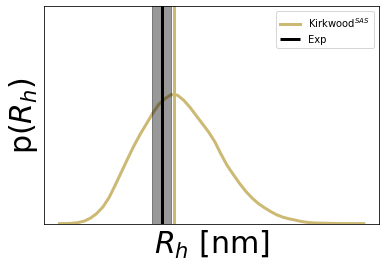

In [484]:
#Tau Kirkwood* Rh

plt.plot(Rh_KirkNew[p][0], Rh_KirkNew[p][1], label=r'Kirkwood$^{SAS}}$',color=c[4], linewidth=3,zorder=-100)
plt.vlines(Rh_KirkNew[p][2],Rh_KirkNew[p][1].min()-1,Rh_KirkNew[p][1].max()+10,color=c[4], linewidth=3)
plt.vlines(dataset.Rh[p],Rh_Nyg[p][1].min()-1,Rh_Nyg[p][1].max()+10,label='Exp',color='k', linewidth=3)
plt.ylim(0,np.max( [Rh_Nyg[p][1].max(), Rh_Kirk[p][1].max(), Rh_HR[p][1].max()] )+0.2)
plt.fill_between((dataset.Rh[p]-dataset.Rh_err[p],dataset.Rh[p]+dataset.Rh_err[p]),0,10,color='k',alpha=0.4)
plt.ylabel(r'p($R_h$)', fontsize=30)
plt.xlabel(r'$R_h$ [nm]', fontsize=30)
plt.legend()
plt.xticks(ticks=[])
plt.yticks(ticks=[])

plt.savefig('fig1_kirk_star.pdf', dpi=300, edgecolor='w', orientation='portrait')
plt.show()